In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

In [3]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import Isomap

In [4]:
data = pd.read_csv(r"cancer.csv")

data.drop_duplicates(inplace=True)

In [5]:
data = data[sorted(data.columns.difference(['id', 'diagnosis', 'Unnamed: 32']).to_list()) + ['diagnosis']]
target = 'diagnosis'

In [6]:
data[target] = data[target].apply(lambda r: 0 if r == 'B' else(1))

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

X = data[data.columns[:-1]]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.88, random_state=1, shuffle=True, stratify=y)

preprocessor = ColumnTransformer(
                    transformers=[
                        ('num', StandardScaler(), X.columns.to_list())
                    ]
                )

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# X = preprocessor.fit_transform(X)

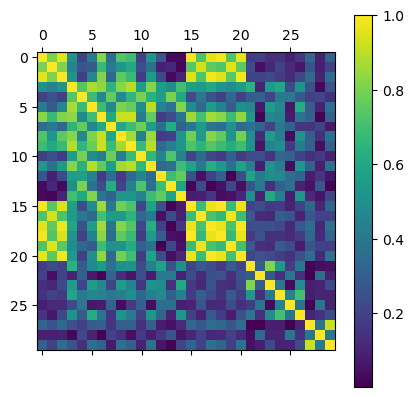

In [8]:
plt.matshow(pd.DataFrame(X_train).corr().abs())
plt.colorbar()
plt.show()

In [10]:
def nullify_values(df):
    n = df.shape[0]  # Assuming equal number of rows and columns
    for i in range(n):
        if i % 3 == 0:
            cols_to_keep = [i, (i + 1) % n, (i + 2) % n]  # Use modulo to handle wrap-around
            df.iloc[i, ~df.columns.isin(df.columns[cols_to_keep])] = False
        else:
            df.iloc[i, :] = False
    return df

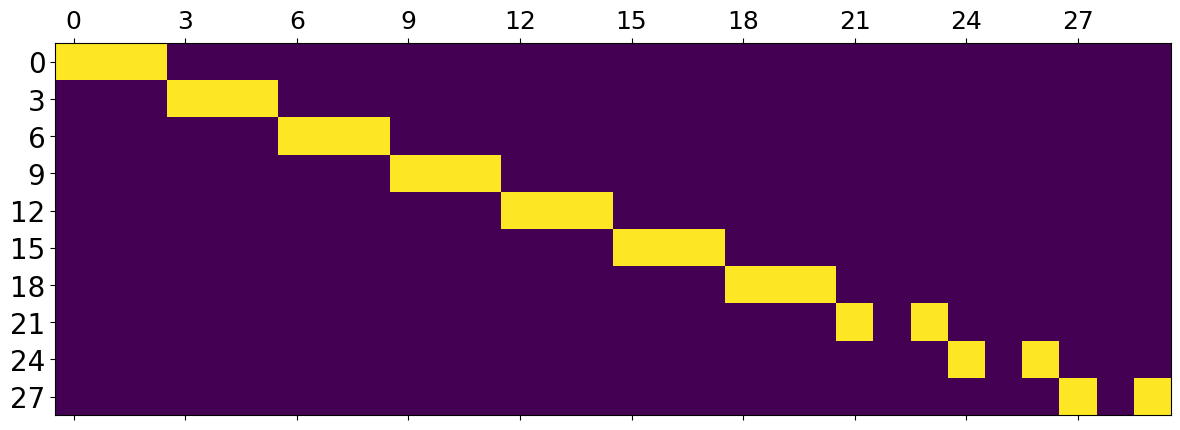

In [259]:
plt.matshow(nullify_values(pd.DataFrame(X_train).corr().abs() > 0.6).iloc[list(range(0, X_train.shape[1], 3)),:])
plt.xticks(range(0, X_train.shape[1], 3), range(0, X_train.shape[1], 3), fontsize=18)
plt.yticks(range(0, 10), range(0, X_train.shape[1], 3), fontsize=20)
plt.show()

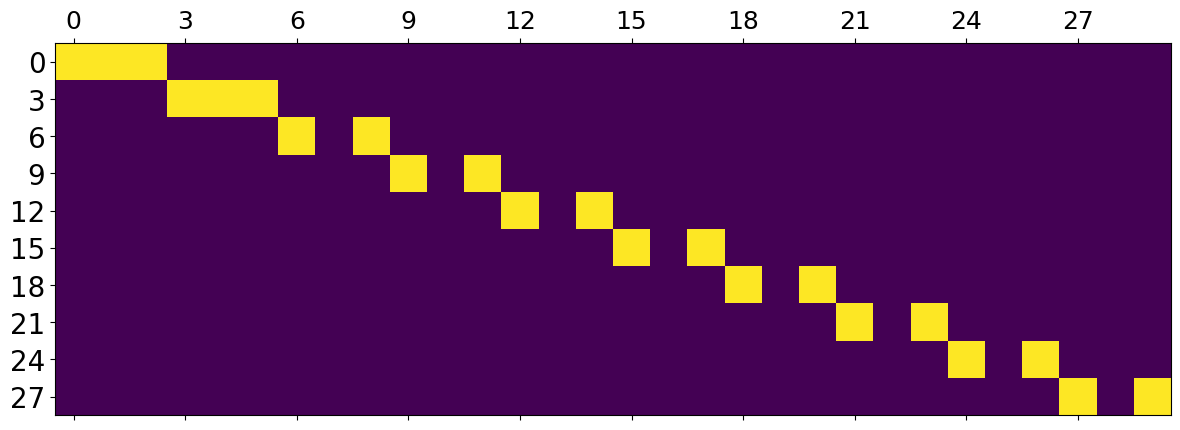

In [12]:
plt.matshow(nullify_values(pd.DataFrame(X_train).corr().abs() > 0.7).iloc[list(range(0, X_train.shape[1], 3)),:])
plt.xticks(range(0, X_train.shape[1], 3), range(0, X_train.shape[1], 3), fontsize=18)
plt.yticks(range(0, 10), range(0, X_train.shape[1], 3), fontsize=20)
plt.show()

In [236]:
print(f'Rank: {np.linalg.matrix_rank(X_train)}')
print(f'Features: {X_train.shape[1]}')

Rank: 30
Features: 30


In [13]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, pairwise_distances

In [14]:
def dunn_index(_X, labels):
    distances = pairwise_distances(_X)
    unique_labels = np.unique(labels)
    
    inter_cluster_distances = []
    intra_cluster_distances = []
    
    for i in unique_labels:
        cluster_i = _X[labels == i]
        intra_cluster_distances.append(np.mean(pairwise_distances(cluster_i)))
        
        for j in unique_labels:
            if i < j:
                cluster_j = _X[labels == j]
                inter_cluster_distances.append(np.min(pairwise_distances(cluster_i, cluster_j)))
                
    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)

In [15]:
kmeans_evals = ['Inertia'] + ['Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index'] # + ['ari', 'nmi', 'fowlkes_mallows']

gmm_evals = ['Log-Likelihood', 'AIC', 'BIC'] + ['Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index'] # + ['ari', 'nmi', 'fowlkes_mallows']

In [16]:
evals= {}
model_data = {}

In [17]:
def dict2data(nested_dict, k1, k2, k3):
    flat_data = []

    for key1, sub_dict1 in nested_dict.items():
        for key2, sub_dict2 in sub_dict1.items():
            for key3, metrics in sub_dict2.items():
                flat_entry = {k1: key1, k2: key2, k3: key3}
                flat_entry.update(metrics)
                flat_data.append(flat_entry)

    _df = pd.DataFrame(flat_data)
    return _df

In [49]:
evals= {}
model_data = {}

evals['kmeans'] = {}
model_data['kmeans'] = {}

for iters in [300, 500]:
    
    evals['kmeans'][iters] = {}
    model_data['kmeans'][iters] = {}
    
    for tol in [1e-2, 1e-4, 1e-6]:
    
        evals['kmeans'][iters][tol] = {}
        model_data['kmeans'][iters][tol] = {}
        
        for k in range(2, 5+1):
            kmeans = KMeans(n_clusters=k, tol=tol, max_iter=500)
            kmeans.fit(pd.DataFrame(X_train, columns=data.columns[:-1]))
            kmeans_labels = kmeans.labels_
            
            # Inertia (Within-Cluster Sum of Squares)
            inertia = kmeans.inertia_
            
            # Silhouette Score
            silhouette = silhouette_score(X_train, kmeans_labels)
            
            # Davies-Bouldin Index
            davies_bouldin = davies_bouldin_score(X_train, kmeans_labels)
            
            # Dunn Index
            dunn = dunn_index(X_train, kmeans_labels)
            
            # # Comparison with ground truth
            ari = adjusted_rand_score(y_train, kmeans_labels)
            nmi = normalized_mutual_info_score(y_train, kmeans_labels)
            fmi = fowlkes_mallows_score(y_train, kmeans_labels)
        
            evals['kmeans'][iters][tol][k] = dict.fromkeys(kmeans_evals, 0)
        
            evals['kmeans'][iters][tol][k]['Inertia'] = inertia
            evals['kmeans'][iters][tol][k]['Silhouette Score'] = silhouette
            evals['kmeans'][iters][tol][k]['Davies-Bouldin Index'] = davies_bouldin
            evals['kmeans'][iters][tol][k]['Dunn Index'] = dunn
            evals['kmeans'][iters][tol][k]['ARI'] = ari
            evals['kmeans'][iters][tol][k]['NMI'] = nmi
            evals['kmeans'][iters][tol][k]['FMI'] = fmi
        
            model_data['kmeans'][iters][tol][k] = {}
            model_data['kmeans'][iters][tol][k]['labels'] = kmeans_labels
            model_data['kmeans'][iters][tol][k]['centers'] = kmeans.cluster_centers_
            model_data['kmeans'][iters][tol][k]['n_iters'] = kmeans.n_iter_
            model_data['kmeans'][iters][tol][k]['feature_names'] = kmeans.feature_names_in_

In [50]:
evals['kmeans']

{300: {0.01: {2: {'Inertia': 10180.216696095558,
    'Silhouette Score': 0.34669339804505594,
    'Davies-Bouldin Index': 1.3131432048455385,
    'Dunn Index': 0.21679030169965793,
    'ARI': 0.6367085766995533,
    'NMI': 0.5174277458174832,
    'FMI': 0.8343330543873766},
   3: {'Inertia': 8876.026280168448,
    'Silhouette Score': 0.30861475908247243,
    'Davies-Bouldin Index': 1.5500347503607543,
    'Dunn Index': 0.20346522492595034,
    'ARI': 0.4903130147723414,
    'NMI': 0.4072071210332367,
    'FMI': 0.7443220386226077},
   4: {'Inertia': 8238.19392667941,
    'Silhouette Score': 0.16170521069254987,
    'Davies-Bouldin Index': 1.907829273659794,
    'Dunn Index': 0.2083136044443889,
    'ARI': 0.29602698230306046,
    'NMI': 0.3606721999756894,
    'FMI': 0.5866312538862947},
   5: {'Inertia': 7773.1782050753845,
    'Silhouette Score': 0.16023486219455607,
    'Davies-Bouldin Index': 1.6336453801025403,
    'Dunn Index': 0.2077028074235866,
    'ARI': 0.2802297136970907,
 

In [51]:
kmeans_evals_df = dict2data(evals['kmeans'], 'iters', 'tol', 'clusters')
# kmeans_evals_df
kmeans_evals_df.style.highlight_max(axis=0, props='background-color:lightgreen;', subset=['Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI']) \
    .highlight_min(axis=0, props='background-color:lightgreen;', subset=['Inertia', 'Davies-Bouldin Index']) \
    .highlight_max(axis=0, props='background-color:pink;', subset=['Inertia', 'Davies-Bouldin Index']) \
    .highlight_min(axis=0, props='background-color:pink;', subset=['Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI'])

,iters,tol,clusters,Inertia,Silhouette Score,Davies-Bouldin Index,Dunn Index,ARI,NMI,FMI
0,300,0.010000,2,10180.216696,0.346693,1.313143,0.216790,0.636709,0.517428,0.834333
1,300,0.010000,3,8876.026280,0.308615,1.550035,0.203465,0.490313,0.407207,0.744322
2,300,0.010000,4,8238.193927,0.161705,1.907829,0.208314,0.296027,0.360672,0.586631
3,300,0.010000,5,7773.178205,0.160235,1.633645,0.207703,0.280230,0.353327,0.572599
4,300,0.000100,2,10179.493964,0.345432,1.318269,0.215724,0.630454,0.508669,0.830713
5,300,0.000100,3,8871.918713,0.313273,1.550939,0.204043,0.504606,0.416193,0.753204
6,300,0.000100,4,8398.161754,0.315593,1.316580,0.234176,0.536277,0.443737,0.766326
7,300,0.000100,5,7564.556512,0.151922,1.795891,0.140308,0.342215,0.416946,0.608439
8,300,0.000001,2,10179.726741,0.346693,1.313143,0.216790,0.636709,0.517428,0.834333
9,300,0.000001,3,8871.789298,0.311357,1.548827,0.204663,0.500378,0.413205,0.750653


In [89]:
kmeans_evals_df.query('(iters == 300) & (tol == 0.0001)')[['tol', 'clusters', 'Inertia', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].rename(columns={'Silhouette Score':'Silhouette', 'Davies-Bouldin Index':'Davies-Bouldin', 'Dunn Index':'Dunn'})
# kmeans_evals_df.query('(iters == 300) & (tol >= 0.0001) & (clusters < 4)')[['tol', 'clusters', 'Inertia', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].rename(columns={'Silhouette Score':'Silhouette', 'Davies-Bouldin Index':'Davies-Bouldin', 'Dunn Index':'Dunn'}) #\
    # .style.highlight_max(axis=0, props='background-color:lightgreen;', subset=['Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI']) \
    # .highlight_min(axis=0, props='background-color:lightgreen;', subset=['Inertia', 'Davies-Bouldin Index']) \
    # .highlight_max(axis=0, props='background-color:pink;', subset=['Inertia', 'Davies-Bouldin Index']) \
    # .highlight_min(axis=0, props='background-color:pink;', subset=['Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI'])

,tol,clusters,Inertia,Silhouette,Davies-Bouldin,Dunn
4,0.0001,2,10179.493964,0.345432,1.318269,0.215724
5,0.0001,3,8871.918713,0.313273,1.550939,0.204043
6,0.0001,4,8398.161754,0.315593,1.316580,0.234176
7,0.0001,5,7564.556512,0.151922,1.795891,0.140308


In [260]:
kmeans_evals_df.query('(iters == 300) & (tol == 0.0001)')[['tol', 'clusters', 'Silhouette Score', 'Davies-Bouldin Index', 'ARI']].rename(columns={'Silhouette Score':'Silhouette', 'Davies-Bouldin Index':'Davies-Bouldin'})

,tol,clusters,Silhouette,Davies-Bouldin,ARI
4,0.0001,2,0.345432,1.318269,0.630454
5,0.0001,3,0.313273,1.550939,0.504606
6,0.0001,4,0.315593,1.316580,0.536277
7,0.0001,5,0.151922,1.795891,0.342215


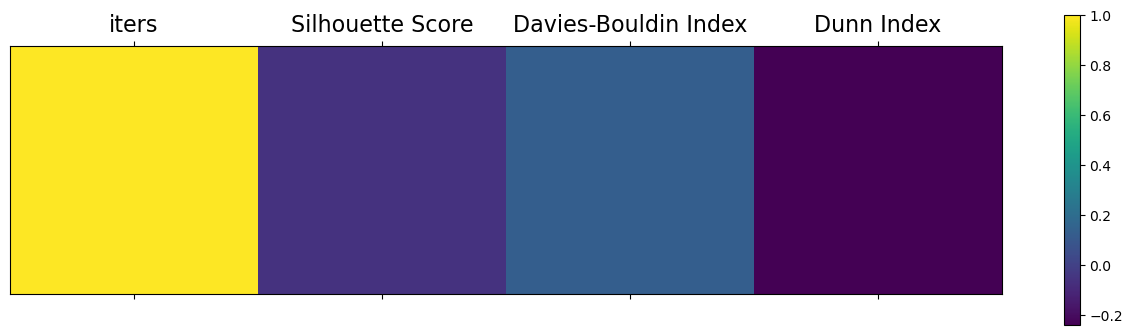

In [53]:
plt.matshow(kmeans_evals_df[['iters', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].corr().iloc[[0]])
plt.colorbar()
plt.xticks([0,1,2,3,], ['iters', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index'], fontsize=16)
plt.yticks([])
plt.show()

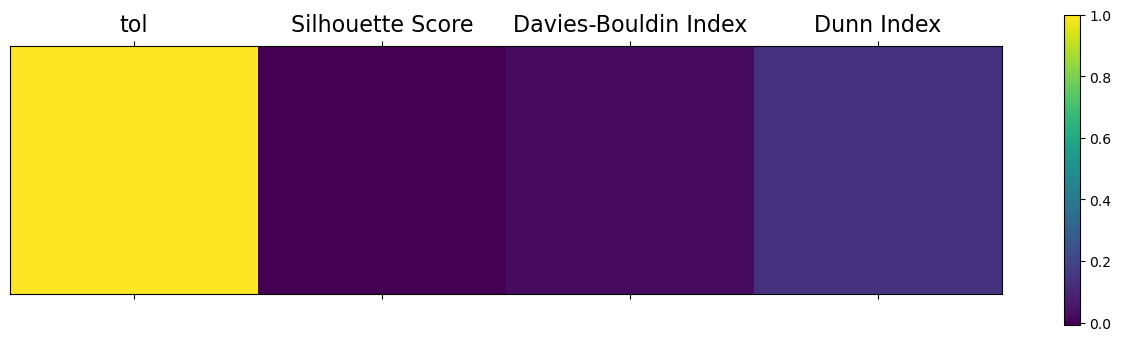

In [54]:
plt.matshow(kmeans_evals_df[['tol', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].corr().iloc[[0]])
plt.colorbar()
plt.xticks([0,1,2,3,], ['tol', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index'], fontsize=16)
plt.yticks([])
plt.show()

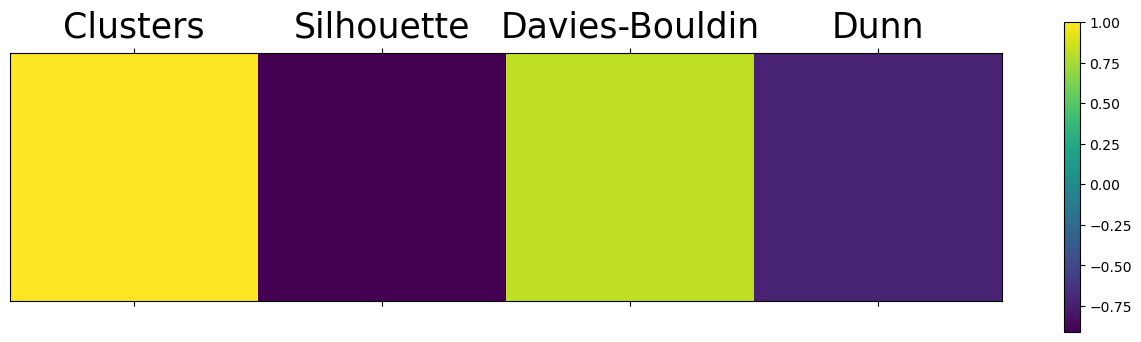

In [85]:
# plt.figure(figsize=(8, 2))
plt.matshow(kmeans_evals_df[['clusters', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].corr().iloc[[0]])
plt.colorbar()
plt.xticks([0,1,2,3,], ['Clusters', 'Silhouette', 'Davies-Bouldin', 'Dunn'], fontsize=25)
plt.yticks([])
plt.show()

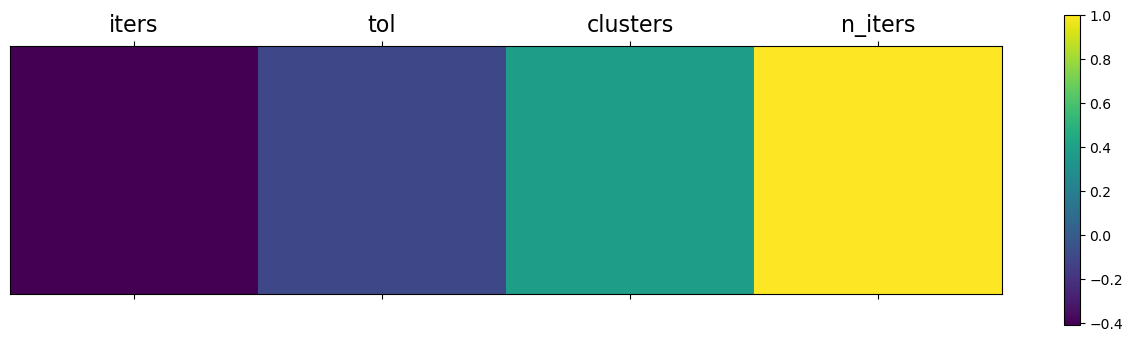

In [46]:
plt.matshow(dict2data(model_data['kmeans'], 'iters', 'tol', 'clusters')[['iters', 'tol', 'clusters', 'n_iters']].corr().iloc[[3]])
plt.colorbar()
plt.xticks([0,1,2,3,], ['iters', 'tol', 'clusters', 'n_iters'], fontsize=16)
plt.yticks([])
plt.show()

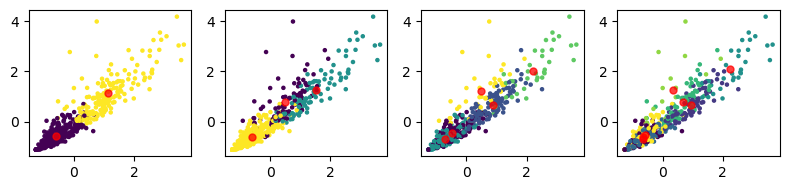

In [22]:
# fig, axes = plt.subplots(
#                 nrows=1, 
#                 ncols=4, 
#                 figsize=(8, 2)
#             )

# axes = axes.flatten()

# for i, ax in zip([2, 3, 5, 7], axes):
#     ax.scatter(X_train[:, 6], X_train[:, 9], c=model_data['kmeans'][i]['labels'], s=5, cmap='viridis')
#     ax.scatter(model_data['kmeans'][i]['centers'][:, 6], model_data['kmeans'][i]['centers'][:, 9], c='red', s=25, alpha=0.75)

# plt.tight_layout()
# plt.show()

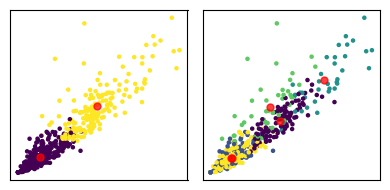

In [87]:
fig, axes = plt.subplots(
                nrows=1, 
                ncols=2, 
                figsize=(4, 2)
            )

axes = axes.flatten()

for i, ax in zip([2, 5], axes):
    ax.scatter(X_train[:, 6], X_train[:, 9], c=model_data['kmeans'][300][0.0001][i]['labels'], s=5, cmap='viridis')
    ax.scatter(model_data['kmeans'][300][0.0001][i]['centers'][:, 6], model_data['kmeans'][300][0.0001][i]['centers'][:, 9], c='red', s=25, alpha=0.75)

    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [67]:
evals['gmm'] = {}
model_data['gmm'] = {}

for iters in [100, 250]:
    
    evals['gmm'][iters] = {}
    model_data['gmm'][iters] = {}
    
    for tol in [1e-2, 1e-3, 1e-4]:
    
        evals['gmm'][iters][tol] = {}
        model_data['gmm'][iters][tol] = {}
        
        for k in range(2, 5+1):
            gmm = GaussianMixture(n_components=k, )
            gmm.fit(pd.DataFrame(X_train, columns=data.columns[:-1]))
            gmm_labels = gmm.predict(pd.DataFrame(X_train, columns=data.columns[:-1]))
            
            # Log-Likelihood
            log_likelihood = gmm.score(pd.DataFrame(X_train, columns=data.columns[:-1]))
            
            # BIC and AIC
            bic = gmm.bic(pd.DataFrame(X_train, columns=data.columns[:-1]))
            aic = gmm.aic(pd.DataFrame(X_train, columns=data.columns[:-1]))
            
            # Silhouette Score
            silhouette = silhouette_score(X_train, gmm_labels)
            
            # Davies-Bouldin Index
            davies_bouldin = davies_bouldin_score(X_train, gmm_labels)
            
            # Dunn Index
            dunn = dunn_index(X_train, gmm_labels)
            
            # # Comparison with ground truth
            ari = adjusted_rand_score(y_train, gmm_labels)
            nmi = normalized_mutual_info_score(y_train, gmm_labels)
            fmi = fowlkes_mallows_score(y_train, gmm_labels)
        
            evals['gmm'][iters][tol][k] = dict.fromkeys(gmm_evals, 0)
            
            evals['gmm'][iters][tol][k]['Log-Likelihood'] = log_likelihood
            evals['gmm'][iters][tol][k]['AIC'] = aic
            evals['gmm'][iters][tol][k]['BIC'] = bic
            evals['gmm'][iters][tol][k]['Silhouette Score'] = silhouette
            evals['gmm'][iters][tol][k]['Davies-Bouldin Index'] = davies_bouldin
            evals['gmm'][iters][tol][k]['Dunn Index'] = dunn
            evals['gmm'][iters][tol][k]['ARI'] = ari
            evals['gmm'][iters][tol][k]['NMI'] = nmi
            evals['gmm'][iters][tol][k]['FMI'] = fmi
        
            model_data['gmm'][iters][tol][k] = {}
            model_data['gmm'][iters][tol][k]['labels'] = gmm_labels
            model_data['gmm'][iters][tol][k]['centers'] = gmm.means_
            model_data['gmm'][iters][tol][k]['n_iters'] = gmm.n_iter_
            model_data['gmm'][iters][tol][k]['feature_names'] = gmm.feature_names_in_

In [68]:
evals['gmm']

{100: {0.01: {2: {'Log-Likelihood': 0.36655217082298713,
    'AIC': 1615.4478291770129,
    'BIC': 5792.124454713405,
    'Silhouette Score': 0.3147919250815686,
    'Davies-Bouldin Index': 1.3822764027421726,
    'Dunn Index': 0.18451342239100285,
    'ARI': 0.7520197041590794,
    'NMI': 0.6362639159361112,
    'FMI': 0.883533253516028},
   3: {'Log-Likelihood': 3.1694627461544522,
    'AIC': -195.46274615445236,
    'BIC': 6071.659496199346,
    'Silhouette Score': 0.2517569582595207,
    'Davies-Bouldin Index': 1.7578440186564361,
    'Dunn Index': 0.20037678366020437,
    'ARI': 0.6034440313294481,
    'NMI': 0.5219332515072143,
    'FMI': 0.7945581173335777},
   4: {'Log-Likelihood': 4.663812287596319,
    'AIC': -697.812287596319,
    'BIC': 7659.755571574887,
    'Silhouette Score': 0.17274383147873598,
    'Davies-Bouldin Index': 1.860319694809065,
    'Dunn Index': 0.15691739739794716,
    'ARI': 0.4227387013255151,
    'NMI': 0.43128319887610334,
    'FMI': 0.676436251257774

In [69]:
gmm_evals_df = dict2data(evals['gmm'], 'iters', 'tol', 'clusters')

gmm_evals_df.style.highlight_max(axis=0, props='background-color:lightgreen;', subset=['Log-Likelihood', 'Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI']) \
    .highlight_min(axis=0, props='background-color:lightgreen;', subset=['AIC', 'BIC', 'Davies-Bouldin Index']) \
    .highlight_max(axis=0, props='background-color:pink;', subset=['AIC', 'BIC', 'Davies-Bouldin Index']) \
    .highlight_min(axis=0, props='background-color:pink;', subset=['Log-Likelihood', 'Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI'])

,iters,tol,clusters,Log-Likelihood,AIC,BIC,Silhouette Score,Davies-Bouldin Index,Dunn Index,ARI,NMI,FMI
0,100,0.010000,2,0.366552,1615.447829,5792.124455,0.314792,1.382276,0.184513,0.752020,0.636264,0.883533
1,100,0.010000,3,3.169463,-195.462746,6071.659496,0.251757,1.757844,0.200377,0.603444,0.521933,0.794558
2,100,0.010000,4,4.663812,-697.812288,7659.755572,0.172744,1.860320,0.156917,0.422739,0.431283,0.676436
3,100,0.010000,5,8.857826,-3899.825628,6548.187848,0.105679,1.948040,0.121132,0.321491,0.398004,0.590245
4,100,0.001000,2,0.389405,1592.594958,5769.271584,0.314085,1.379513,0.185808,0.766051,0.652289,0.890124
5,100,0.001000,3,3.169463,-195.462746,6071.659496,0.251757,1.757844,0.200377,0.603444,0.521933,0.794558
6,100,0.001000,4,6.034481,-2068.481073,6289.086786,0.175229,1.623538,0.132997,0.446059,0.419358,0.694706
7,100,0.001000,5,8.603428,-3645.427838,6802.585638,0.118480,1.922833,0.165259,0.340750,0.422219,0.603489
8,100,0.000100,2,0.389405,1592.595141,5769.271766,0.314085,1.379513,0.185808,0.766051,0.652289,0.890124
9,100,0.000100,3,3.169463,-195.462746,6071.659496,0.251757,1.757844,0.200377,0.603444,0.521933,0.794558


In [91]:
gmm_evals_df.query('(iters == 100) & (tol == 0.001)')[['tol', 'clusters', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].rename(columns={'Silhouette Score':'Silhouette', 'Davies-Bouldin Index':'Davies-Bouldin', 'Dunn Index':'Dunn'})
# kmeans_evals_df.query('(iters == 300) & (tol >= 0.0001) & (clusters < 4)')[['tol', 'clusters', 'Inertia', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].rename(columns={'Silhouette Score':'Silhouette', 'Davies-Bouldin Index':'Davies-Bouldin', 'Dunn Index':'Dunn'}) #\
    # .style.highlight_max(axis=0, props='background-color:lightgreen;', subset=['Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI']) \
    # .highlight_min(axis=0, props='background-color:lightgreen;', subset=['Inertia', 'Davies-Bouldin Index']) \
    # .highlight_max(axis=0, props='background-color:pink;', subset=['Inertia', 'Davies-Bouldin Index']) \
    # .highlight_min(axis=0, props='background-color:pink;', subset=['Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI'])

,tol,clusters,Silhouette,Davies-Bouldin,Dunn
4,0.001,2,0.314085,1.379513,0.185808
5,0.001,3,0.251757,1.757844,0.200377
6,0.001,4,0.175229,1.623538,0.132997
7,0.001,5,0.118480,1.922833,0.165259


In [261]:
gmm_evals_df.query('(iters == 100) & (tol == 0.001)')[['tol', 'clusters', 'Silhouette Score', 'Davies-Bouldin Index', 'ARI']].rename(columns={'Silhouette Score':'Silhouette', 'Davies-Bouldin Index':'Davies-Bouldin'})

,tol,clusters,Silhouette,Davies-Bouldin,ARI
4,0.001,2,0.314085,1.379513,0.766051
5,0.001,3,0.251757,1.757844,0.603444
6,0.001,4,0.175229,1.623538,0.446059
7,0.001,5,0.118480,1.922833,0.340750


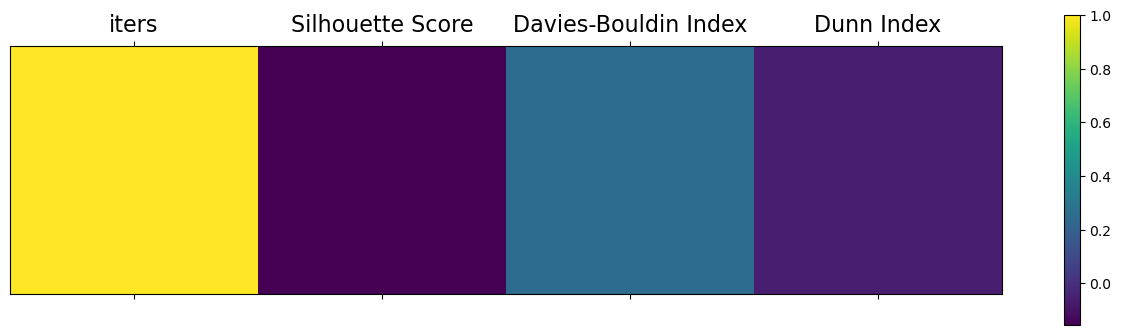

In [71]:
plt.matshow(gmm_evals_df[['iters', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].corr().iloc[[0]])
plt.colorbar()
plt.xticks([0,1,2,3,], ['iters', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index'], fontsize=16)
plt.yticks([])
plt.show()

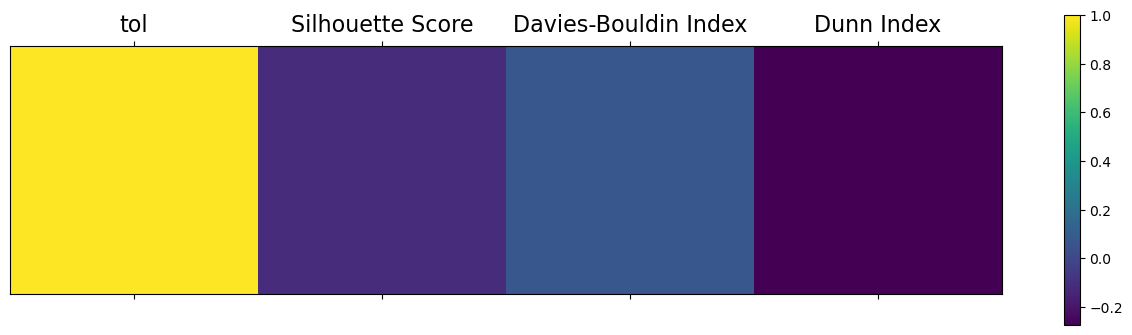

In [72]:
plt.matshow(gmm_evals_df[['tol', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].corr().iloc[[0]])
plt.colorbar()
plt.xticks([0,1,2,3,], ['tol', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index'], fontsize=16)
plt.yticks([])
plt.show()

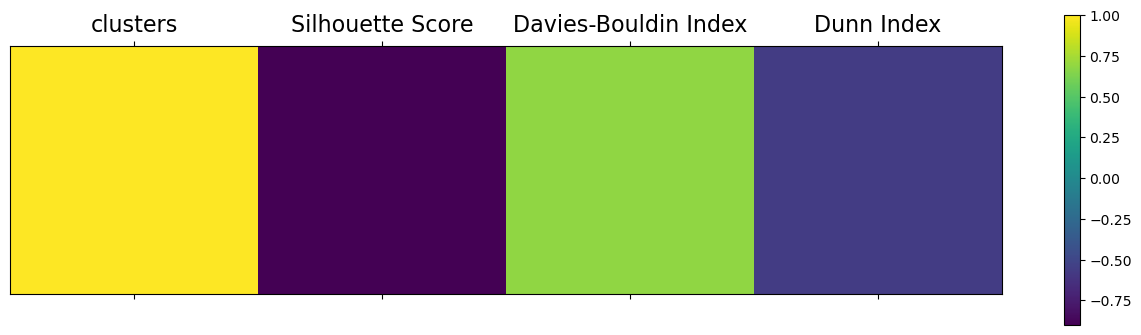

In [73]:
plt.matshow(gmm_evals_df[['clusters', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].corr().iloc[[0]])
plt.colorbar()
plt.xticks([0,1,2,3,], ['clusters', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index'], fontsize=16)
plt.yticks([])
plt.show()

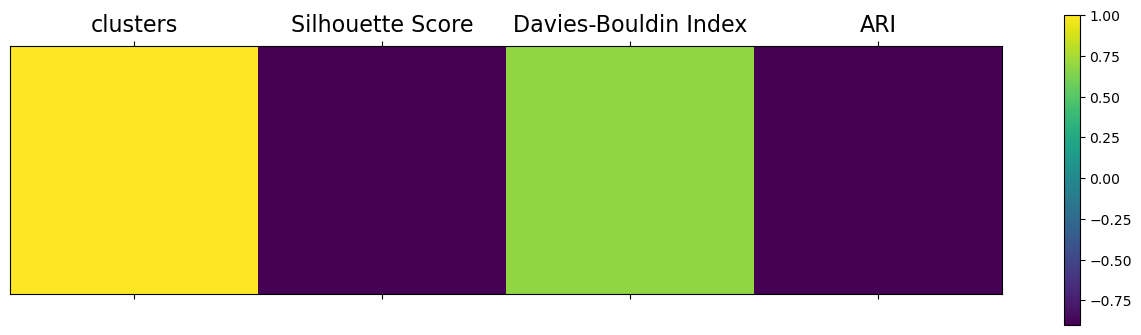

In [265]:
plt.matshow(gmm_evals_df[['clusters', 'Silhouette Score', 'Davies-Bouldin Index', 'ARI']].corr().iloc[[0]])
plt.colorbar()
plt.xticks([0,1,2,3,], ['clusters', 'Silhouette Score', 'Davies-Bouldin Index', 'ARI'], fontsize=16)
plt.yticks([])
plt.show()

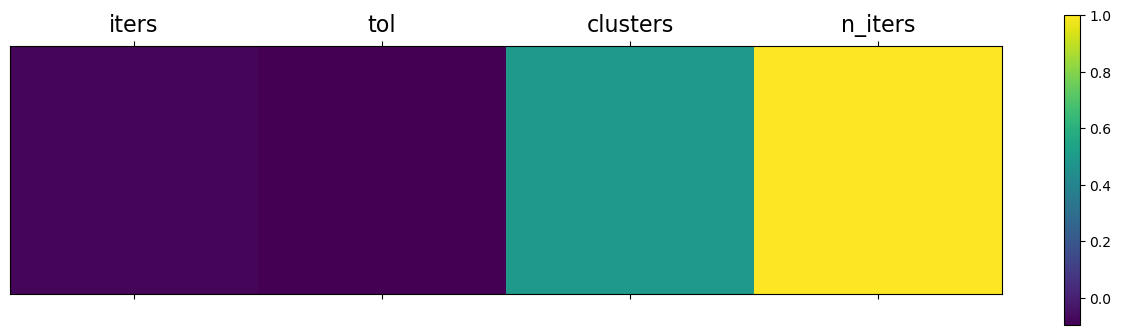

In [74]:
plt.matshow(dict2data(model_data['gmm'], 'iters', 'tol', 'clusters')[['iters', 'tol', 'clusters', 'n_iters']].corr().iloc[[3]])
plt.colorbar()
plt.xticks([0,1,2,3,], ['iters', 'tol', 'clusters', 'n_iters'], fontsize=16)
plt.yticks([])
plt.show()

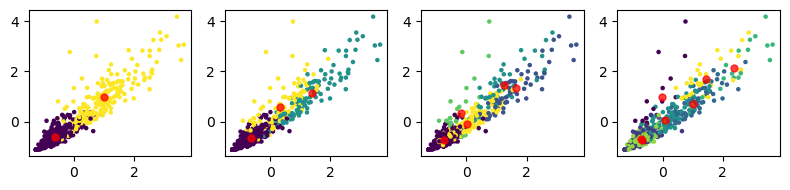

In [28]:
# fig, axes = plt.subplots(
#                 nrows=1, 
#                 ncols=4, 
#                 figsize=(8, 2)
#             )

# axes = axes.flatten()

# for i, ax in zip([2, 3, 5, 7], axes):
#     ax.scatter(X_train[:, 6], X_train[:, 9], c=model_data['gmm'][i]['labels'], s=5, cmap='viridis')
#     ax.scatter(model_data['gmm'][i]['centers'][:, 6], model_data['gmm'][i]['centers'][:, 9], c='red', s=25, alpha=0.75)

# plt.tight_layout()
# plt.show()

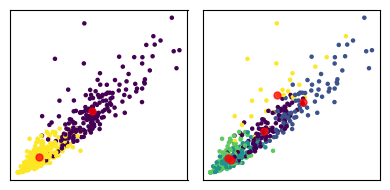

In [76]:
fig, axes = plt.subplots(
                nrows=1, 
                ncols=2, 
                figsize=(4, 2)
            )

axes = axes.flatten()

for i, ax in zip([2, 5], axes):
    ax.scatter(X_train[:, 6], X_train[:, 9], c=model_data['gmm'][100][0.001][i]['labels'], s=5, cmap='viridis')
    ax.scatter(model_data['gmm'][100][0.001][i]['centers'][:, 6], model_data['gmm'][100][0.001][i]['centers'][:, 9], c='red', s=25, alpha=0.75)

    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [78]:
dict2data(model_data['gmm'], 'iters', 'tol', 'clusters')[['iters', 'tol', 'clusters', 'n_iters']]

,iters,tol,clusters,n_iters
0,100,0.0100,2,10
1,100,0.0100,3,16
2,100,0.0100,4,17
3,100,0.0100,5,13
4,100,0.0010,2,10
5,100,0.0010,3,16
6,100,0.0010,4,12
7,100,0.0010,5,20
8,100,0.0001,2,9
9,100,0.0001,3,16


### Dimnsionality Reduction

In [92]:
import time

dim_red_times = {}

In [93]:
# Fit PCA
pca = PCA().fit(X_train)

# Explained variance
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

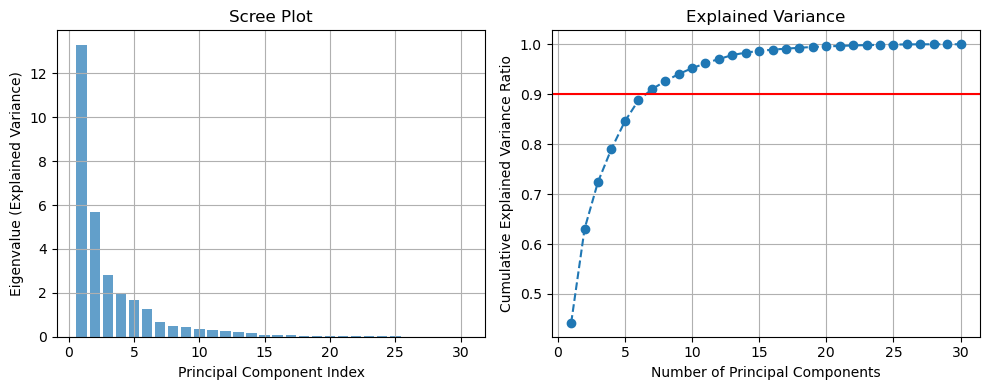

In [96]:
# Plot explained variance
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', label='Individual explained variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Eigenvalue (Explained Variance)')
plt.title('Scree Plot')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--', label='Cumulative explained variance')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance')
plt.grid(True)

plt.tight_layout()
plt.show()

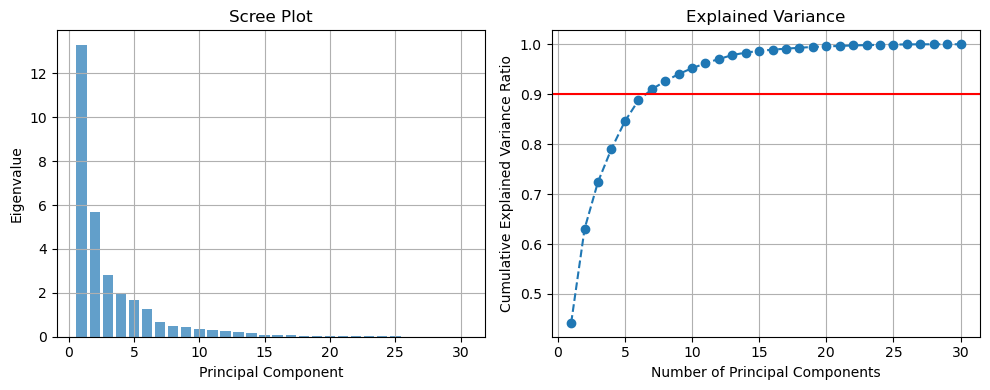

In [267]:
# Plot explained variance
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', label='Individual explained variance')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--', label='Cumulative explained variance')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance')
plt.grid(True)

plt.tight_layout()
plt.show()

In [97]:
pca_nc = 7
pca = PCA(n_components=pca_nc, )

st = time.time()
X_train_pca = pca.fit_transform(X_train)
dim_red_times['pca'] = time.time() - st

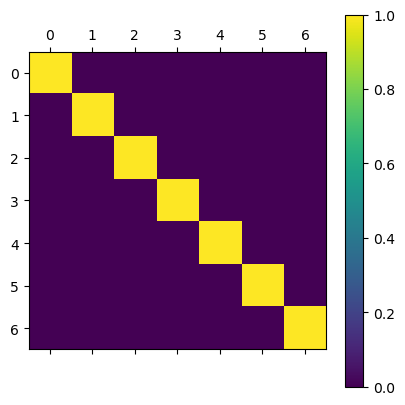

In [98]:
plt.matshow(pd.DataFrame(X_train_pca).corr().abs())
plt.colorbar()
plt.show()

In [99]:
from scipy.stats import kurtosis

# Function to compute kurtosis for ICA components
def compute_kurtosis(_X, n_components):
    ica = FastICA(n_components=n_components, tol=0.001, max_iter=10000)
    X_ica = ica.fit_transform(_X)
    kurt_values = kurtosis(X_ica, fisher=False)
    avg_kurtosis = np.mean(np.abs(kurt_values))
    return ica, X_ica, kurt_values, avg_kurtosis

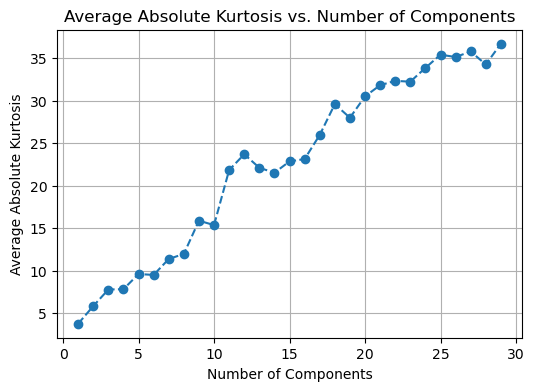

In [100]:
# Evaluate different numbers of components
components_range = range(1, X_train.shape[1])
avg_kurtosis_values = []

for n in components_range:
    ica_model, ica_X, _, avg_kurt = compute_kurtosis(X_train, n)
    avg_kurtosis_values.append(avg_kurt)

# Plot average kurtosis values
plt.figure(figsize=(6, 4))
plt.plot(components_range, avg_kurtosis_values, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Average Absolute Kurtosis')
plt.title('Average Absolute Kurtosis vs. Number of Components')
plt.grid(True)
plt.show()

In [101]:
ica_nc = 18
ica, X_train_ica, kurt_values, avg_kurt = compute_kurtosis(X_train, ica_nc)
print(f"Kurtosis values for {ica_nc} components:")
print(kurt_values)
print(f"Average Absolute Kurtosis for {ica_nc} components: {avg_kurt:.4f}")

top_ica_components = np.argsort(np.abs(kurt_values))[-int((ica_nc+1)/2):]  # Select top half components by absolute kurtosis

Kurtosis values for 18 components:
[  7.92218547   8.99615799   5.99780675  48.7332657    5.60208849
  10.06977587  14.82520335  25.91881877 188.64449027   7.05819065
  18.07998233   4.87156516   8.38026554  13.87377451  11.95626115
 116.14081169   2.4727318   15.14068065]
Average Absolute Kurtosis for 18 components: 28.5936


In [102]:
# Fit ICA and project on top components
X_train_ica_selected = X_train_ica[:, list(reversed(top_ica_components.tolist()))]

print(f"Selected top components based on kurtosis: {top_ica_components}")

Selected top components based on kurtosis: [14 13  6 17 10  7  3 15  8]


In [103]:
st = time.time()
FastICA(n_components=ica_nc, tol=0.001, max_iter=10000).fit_transform(X_train)
dim_red_times['ica'] = time.time() - st

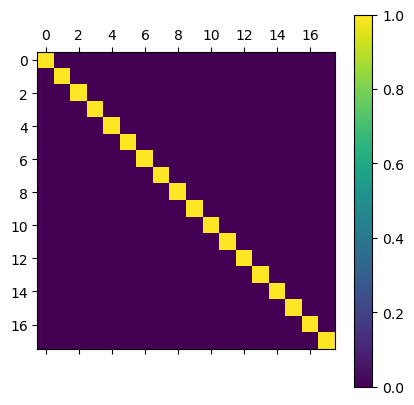

In [104]:
plt.matshow(pd.DataFrame(X_train_ica).corr().abs())
plt.colorbar()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

def compute_reconstruction_error(_X, n_components):
    rp = GaussianRandomProjection(n_components=n_components, )
    X_rp_projected = rp.fit_transform(_X)
    W = rp.components_  # Projection matrix
    W_pseudo_inverse = np.linalg.pinv(W)  # Pseudo inverse of the projection matrix
    X_rp_reconstructed = X_rp_projected @ W_pseudo_inverse.T  # Reconstruct the data
    reconstruction_error = mean_squared_error(_X, X_rp_reconstructed)
    return reconstruction_error

# Evaluate different numbers of components
reconstruction_errors = []

for n in components_range:
    recon_error = compute_reconstruction_error(X_train, n)
    reconstruction_errors.append(recon_error)

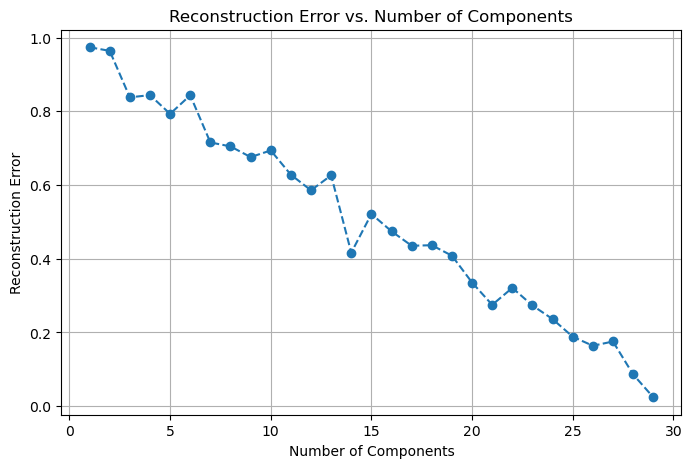

In [118]:
# Plot reconstruction errors
plt.figure(figsize=(8, 5))
plt.plot(components_range, reconstruction_errors, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs. Number of Components')
plt.grid(True)
plt.show()

In [114]:
rp_nc = 21

rp = GaussianRandomProjection(n_components=rp_nc, )
st = time.time()
X_train_rp = rp.fit_transform(X_train)
dim_red_times['rp'] = time.time() - st

W = rp.components_  # Projection matrix
W_pseudo_inverse = np.linalg.pinv(W)  # Pseudo inverse of the projection matrix
X_train_rp_reconstructed = X_train_rp @ W_pseudo_inverse.T  # Reconstruct the data
reconstruction_error = mean_squared_error(X_train, X_train_rp_reconstructed)
print(reconstruction_error)

0.23008862614505932


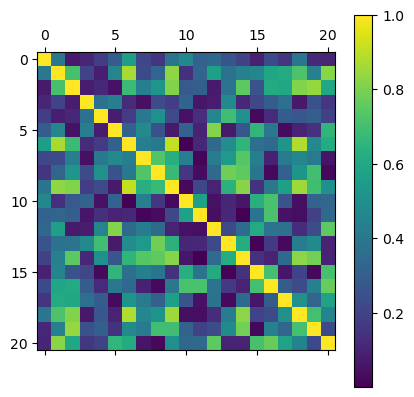

In [119]:
plt.matshow(pd.DataFrame(X_train_rp).corr().abs())
plt.colorbar()
plt.show()

In [253]:
rp_error_var = []

for i in range(1000):
    rp_error_var.append(compute_reconstruction_error(X_train, rp_nc))

print(f'Reconstrucion Error - Mean: {np.mean(rp_error_var)}')
print(f'Reconstrucion Error - Stdv: {np.std(rp_error_var)}')

Reconstrucion Error - Mean: 0.3004478264065926
Reconstrucion Error - Stdv: 0.05388840393847845


In [120]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist

def compute_residual_variance(_X, n_components):
    isomap = Isomap(n_components=n_components)
    X_isomap = isomap.fit_transform(_X)
    
    # Compute pairwise distances
    D_original = pairwise_distances(_X)
    D_isomap = pairwise_distances(X_isomap)
    
    # Compute squared correlation coefficient (R^2)
    D_original_flat = D_original.flatten()
    D_isomap_flat = D_isomap.flatten()
    correlation_matrix = np.corrcoef(D_original_flat, D_isomap_flat)
    R2 = correlation_matrix[0, 1] ** 2
    
    # Residual variance
    residual_variance = 1 - R2
    return residual_variance

In [123]:
# Evaluate different numbers of components
residual_variances = []

for n in components_range:
    residual_variance = compute_residual_variance(X_train, n)
    residual_variances.append(residual_variance)

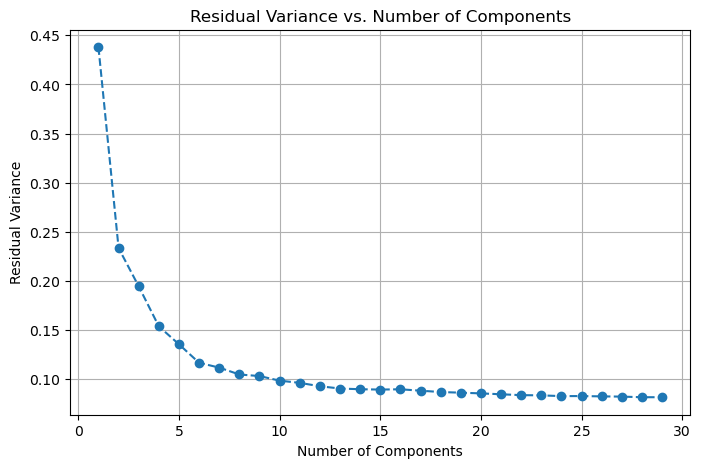

In [124]:
# Plot residual variances
plt.figure(figsize=(8, 5))
plt.plot(components_range, residual_variances, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Residual Variance')
plt.title('Residual Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [125]:
isomap_nc = 6

isomap = Isomap(n_components=isomap_nc)

st = time.time()
X_train_isomap = isomap.fit_transform(X_train)
dim_red_times['isomap'] = time.time() - st

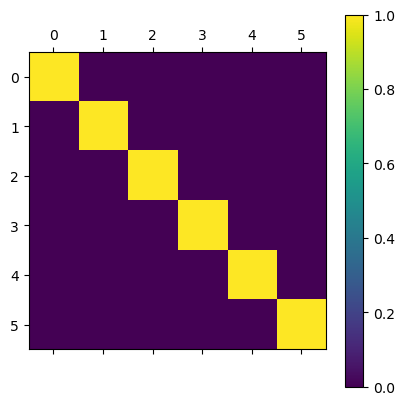

In [126]:
plt.matshow(pd.DataFrame(X_train_isomap).corr().abs())
plt.colorbar()
plt.show()

In [238]:
kurt_values

array([  7.92218547,   8.99615799,   5.99780675,  48.7332657 ,
         5.60208849,  10.06977587,  14.82520335,  25.91881877,
       188.64449027,   7.05819065,  18.07998233,   4.87156516,
         8.38026554,  13.87377451,  11.95626115, 116.14081169,
         2.4727318 ,  15.14068065])

In [240]:
np.argmax(kurt_values)

8

C:\Users\msarm\AppData\Local\Temp\ipykernel_33048\4102171727.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], s=5, cmap='viridis')
C:\Users\msarm\AppData\Local\Temp\ipykernel_33048\4102171727.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_train_ica[:, 8], X_train_ica[:, -3], s=5, cmap='viridis')


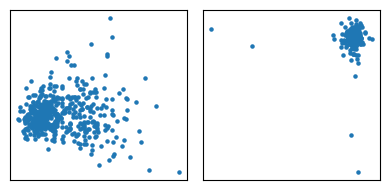

In [242]:
fig, axes = plt.subplots(
                nrows=1, 
                ncols=2, 
                figsize=(4, 2)
            )

axes = axes.flatten()

for dr, ax in zip(['pca', 'ica'], axes):
    if dr == 'pca':
        ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], s=5, cmap='viridis')
    elif dr == 'ica':
        ax.scatter(X_train_ica[:, 8], X_train_ica[:, -3], s=5, cmap='viridis')
    

    
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [162]:
cluster_times = {}

cluster_times['kmeans'] = {}
cluster_times['gmm'] = {}

In [164]:
# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, )
st = time.time()
gmm.fit(pd.DataFrame(X_train, columns=data.columns[:-1]))
cluster_times['gmm']['baseline'] = time.time() - st
gmm_labels = gmm.predict(pd.DataFrame(X_train, columns=data.columns[:-1]))

# Fit KMeans
kmeans = KMeans(n_clusters=2, )
st = time.time()
kmeans.fit(pd.DataFrame(X_train, columns=data.columns[:-1]))
cluster_times['kmeans']['baseline'] = time.time() - st
kmeans_labels = kmeans.predict(pd.DataFrame(X_train, columns=data.columns[:-1]))

In [165]:
# Fit Gaussian Mixture Model
gmm_pca = GaussianMixture(n_components=2, )
st = time.time()
gmm_pca.fit(pd.DataFrame(X_train_pca, columns=[f'Component {i}' for i in range(1, X_train_pca.shape[1]+1)]))
cluster_times['gmm']['pca'] = time.time() - st
gmm_pca_labels = gmm_pca.predict(pd.DataFrame(X_train_pca, columns=[f'Component {i}' for i in range(1, X_train_pca.shape[1]+1)]))

# Fit KMeans
kmeans_pca = KMeans(n_clusters=2, )
st = time.time()
kmeans_pca.fit(pd.DataFrame(X_train_pca, columns=[f'Component {i}' for i in range(1, X_train_pca.shape[1]+1)]))
cluster_times['kmeans']['pca'] = time.time() - st
kmeans_pca_labels = kmeans_pca.predict(pd.DataFrame(X_train_pca, columns=[f'Component {i}' for i in range(1, X_train_pca.shape[1]+1)]))

In [166]:
# Fit Gaussian Mixture Model
gmm_ica = GaussianMixture(n_components=2, )
st = time.time()
gmm_ica.fit(pd.DataFrame(X_train_ica, columns=[f'Component {i}' for i in range(1, X_train_ica.shape[1]+1)]))
cluster_times['gmm']['ica'] = time.time() - st
gmm_ica_labels = gmm_ica.predict(pd.DataFrame(X_train_ica, columns=[f'Component {i}' for i in range(1, X_train_ica.shape[1]+1)]))

# Fit KMeans
kmeans_ica = KMeans(n_clusters=2, )
st = time.time()
kmeans_ica.fit(pd.DataFrame(X_train_ica, columns=[f'Component {i}' for i in range(1, X_train_ica.shape[1]+1)]))
cluster_times['kmeans']['ica'] = time.time() - st
kmeans_ica_labels = kmeans_ica.predict(pd.DataFrame(X_train_ica, columns=[f'Component {i}' for i in range(1, X_train_ica.shape[1]+1)]))

In [167]:
# # Fit Gaussian Mixture Model
# gmm_ica_selected = GaussianMixture(n_components=2, )
# st = time.time()
# gmm_ica_selected.fit(X_train_ica_selected)
# cluster_times['gmm']['ica_subset'] = time.time() - st
# gmm_ica_selected_labels = gmm_ica_selected.predict(X_train_ica_selected)

# # Fit KMeans
# kmeans_ica_selected = KMeans(n_clusters=2, )
# st = time.time()
# kmeans_ica_selected.fit(X_train_ica_selected)
# cluster_times['kmeans']['ica_subset'] = time.time() - st
# kmeans_ica_selected_labels = kmeans_ica_selected.predict(X_train_ica_selected)

In [168]:
# Fit Gaussian Mixture Model
gmm_rp = GaussianMixture(n_components=2, )
st = time.time()
gmm_rp.fit(pd.DataFrame(X_train_rp, columns=[f'Component {i}' for i in range(1, X_train_rp.shape[1]+1)]))
cluster_times['gmm']['rp'] = time.time() - st
gmm_rp_labels = gmm_rp.predict(pd.DataFrame(X_train_rp, columns=[f'Component {i}' for i in range(1, X_train_rp.shape[1]+1)]))

# Fit KMeans
kmeans_rp = KMeans(n_clusters=2, )
st = time.time()
kmeans_rp.fit(pd.DataFrame(X_train_rp, columns=[f'Component {i}' for i in range(1, X_train_rp.shape[1]+1)]))
cluster_times['kmeans']['rp'] = time.time() - st
kmeans_rp_labels = kmeans_rp.predict(pd.DataFrame(X_train_rp, columns=[f'Component {i}' for i in range(1, X_train_rp.shape[1]+1)]))

In [169]:
# Fit Gaussian Mixture Model
gmm_isomap = GaussianMixture(n_components=2, )
st = time.time()
gmm_isomap.fit(pd.DataFrame(X_train_isomap, columns=[f'Component {i}' for i in range(1, X_train_isomap.shape[1]+1)]))
cluster_times['gmm']['isomap'] = time.time() - st
gmm_isomap_labels = gmm_isomap.predict(pd.DataFrame(X_train_isomap, columns=[f'Component {i}' for i in range(1, X_train_isomap.shape[1]+1)]))

# Fit KMeans
kmeans_isomap = KMeans(n_clusters=2, )
st = time.time()
kmeans_isomap.fit(pd.DataFrame(X_train_isomap, columns=[f'Component {i}' for i in range(1, X_train_isomap.shape[1]+1)]))
cluster_times['kmeans']['isomap'] = time.time() - st
kmeans_isomap_labels = kmeans_isomap.predict(pd.DataFrame(X_train_isomap, columns=[f'Component {i}' for i in range(1, X_train_isomap.shape[1]+1)]))

In [170]:
red_clustering_evals = {}

red_clustering_model_data = {}

In [171]:
red_clustering_evals['kmeans'] = {}
red_clustering_model_data['kmeans'] = {}

In [190]:
red_clustering_evals['kmeans']['baseline'] = {}
red_clustering_model_data['kmeans']['baseline'] = {}

red_clustering_evals['kmeans']['baseline']['Inertia'] = kmeans.inertia_
red_clustering_evals['kmeans']['baseline']['Silhouette Score'] = silhouette_score(X_train, kmeans_labels)
red_clustering_evals['kmeans']['baseline']['Davies-Bouldin Index'] = davies_bouldin_score(X_train, kmeans_labels)
red_clustering_evals['kmeans']['baseline']['Dunn Index'] = dunn_index(X_train, kmeans_labels)
red_clustering_evals['kmeans']['baseline']['ARI'] = adjusted_rand_score(y_train, kmeans_labels)
red_clustering_evals['kmeans']['baseline']['NMI'] = normalized_mutual_info_score(y_train, kmeans_labels)
red_clustering_evals['kmeans']['baseline']['FMI'] = fowlkes_mallows_score(y_train, kmeans_labels)

red_clustering_model_data['kmeans']['baseline'] = {}
red_clustering_model_data['kmeans']['baseline']['labels'] = kmeans_labels
red_clustering_model_data['kmeans']['baseline']['centers'] = kmeans.cluster_centers_
red_clustering_model_data['kmeans']['baseline']['n_iters'] = kmeans.n_iter_
red_clustering_model_data['kmeans']['baseline']['feature_names'] = kmeans.feature_names_in_

In [191]:
red_clustering_evals['kmeans']['pca'] = {}
red_clustering_model_data['kmeans']['pca'] = {}

red_clustering_evals['kmeans']['pca']['Inertia'] = kmeans_pca.inertia_
red_clustering_evals['kmeans']['pca']['Silhouette Score'] = silhouette_score(X_train_pca, kmeans_pca_labels)
red_clustering_evals['kmeans']['pca']['Davies-Bouldin Index'] = davies_bouldin_score(X_train_pca, kmeans_pca_labels)
red_clustering_evals['kmeans']['pca']['Dunn Index'] = dunn_index(X_train_pca, kmeans_pca_labels)
red_clustering_evals['kmeans']['pca']['ARI'] = adjusted_rand_score(y_train, kmeans_pca_labels)
red_clustering_evals['kmeans']['pca']['NMI'] = normalized_mutual_info_score(y_train, kmeans_pca_labels)
red_clustering_evals['kmeans']['pca']['FMI'] = fowlkes_mallows_score(y_train, kmeans_pca_labels)

red_clustering_model_data['kmeans']['pca'] = {}
red_clustering_model_data['kmeans']['pca']['labels'] = kmeans_pca_labels
red_clustering_model_data['kmeans']['pca']['centers'] = kmeans_pca.cluster_centers_
red_clustering_model_data['kmeans']['pca']['n_iters'] = kmeans_pca.n_iter_
red_clustering_model_data['kmeans']['pca']['feature_names'] = kmeans_pca.feature_names_in_

In [192]:
red_clustering_evals['kmeans']['ica'] = {}
red_clustering_model_data['kmeans']['ica'] = {}

red_clustering_evals['kmeans']['ica']['Inertia'] = kmeans_ica.inertia_
red_clustering_evals['kmeans']['ica']['Silhouette Score'] = silhouette_score(X_train_ica, kmeans_ica_labels)
red_clustering_evals['kmeans']['ica']['Davies-Bouldin Index'] = davies_bouldin_score(X_train_ica, kmeans_ica_labels)
red_clustering_evals['kmeans']['ica']['Dunn Index'] = dunn_index(X_train_ica, kmeans_ica_labels)
red_clustering_evals['kmeans']['ica']['ARI'] = adjusted_rand_score(y_train, kmeans_ica_labels)
red_clustering_evals['kmeans']['ica']['NMI'] = normalized_mutual_info_score(y_train, kmeans_ica_labels)
red_clustering_evals['kmeans']['ica']['FMI'] = fowlkes_mallows_score(y_train, kmeans_ica_labels)

red_clustering_model_data['kmeans']['ica'] = {}
red_clustering_model_data['kmeans']['ica']['labels'] = kmeans_ica_labels
red_clustering_model_data['kmeans']['ica']['centers'] = kmeans_ica.cluster_centers_
red_clustering_model_data['kmeans']['ica']['n_iters'] = kmeans_ica.n_iter_
red_clustering_model_data['kmeans']['ica']['feature_names'] = kmeans_ica.feature_names_in_

In [193]:
# red_clustering_evals['kmeans']['ica_subset'] = {}
# red_clustering_model_data['kmeans']['ica_subset'] = {}

# red_clustering_evals['kmeans']['ica_subset']['Inertia'] = kmeans_ica_selected.inertia_
# red_clustering_evals['kmeans']['ica_subset']['Silhouette Score'] = silhouette_score(X_train_ica_selected, kmeans_ica_selected_labels)
# red_clustering_evals['kmeans']['ica_subset']['Davies-Bouldin Index'] = davies_bouldin_score(X_train_ica_selected, kmeans_ica_selected_labels)
# red_clustering_evals['kmeans']['ica_subset']['Dunn Index'] = dunn_index(X_train_ica_selected, kmeans_ica_selected_labels)
# red_clustering_evals['kmeans']['ica_subset']['ARI'] = adjusted_rand_score(y_train, kmeans_ica_selected_labels)
# red_clustering_evals['kmeans']['ica_subset']['NMI'] = normalized_mutual_info_score(y_train, kmeans_ica_selected_labels)
# red_clustering_evals['kmeans']['ica_subset']['FMI'] = fowlkes_mallows_score(y_train, kmeans_ica_selected_labels)

# red_clustering_model_data['kmeans']['ica_subset'] = {}
# red_clustering_model_data['kmeans']['ica_subset']['labels'] = kmeans_ica_selected_labels
# red_clustering_model_data['kmeans']['ica_subset']['centers'] = kmeans_ica_selected.cluster_centers_

In [194]:
red_clustering_evals['kmeans']['rp'] = {}
red_clustering_model_data['kmeans']['rp'] = {}

red_clustering_evals['kmeans']['rp']['Inertia'] = kmeans_rp.inertia_
red_clustering_evals['kmeans']['rp']['Silhouette Score'] = silhouette_score(X_train_rp, kmeans_rp_labels)
red_clustering_evals['kmeans']['rp']['Davies-Bouldin Index'] = davies_bouldin_score(X_train_rp, kmeans_rp_labels)
red_clustering_evals['kmeans']['rp']['Dunn Index'] = dunn_index(X_train_rp, kmeans_rp_labels)
red_clustering_evals['kmeans']['rp']['ARI'] = adjusted_rand_score(y_train, kmeans_rp_labels)
red_clustering_evals['kmeans']['rp']['NMI'] = normalized_mutual_info_score(y_train, kmeans_rp_labels)
red_clustering_evals['kmeans']['rp']['FMI'] = fowlkes_mallows_score(y_train, kmeans_rp_labels)

red_clustering_model_data['kmeans']['rp'] = {}
red_clustering_model_data['kmeans']['rp']['labels'] = kmeans_rp_labels
red_clustering_model_data['kmeans']['rp']['centers'] = kmeans_rp.cluster_centers_
red_clustering_model_data['kmeans']['rp']['n_iters'] = kmeans_rp.n_iter_
red_clustering_model_data['kmeans']['rp']['feature_names'] = kmeans_rp.feature_names_in_

In [195]:
red_clustering_evals['kmeans']['isomap'] = {}
red_clustering_model_data['kmeans']['isomap'] = {}

red_clustering_evals['kmeans']['isomap']['Inertia'] = kmeans_isomap.inertia_
red_clustering_evals['kmeans']['isomap']['Silhouette Score'] = silhouette_score(X_train_isomap, kmeans_isomap_labels)
red_clustering_evals['kmeans']['isomap']['Davies-Bouldin Index'] = davies_bouldin_score(X_train_isomap, kmeans_isomap_labels)
red_clustering_evals['kmeans']['isomap']['Dunn Index'] = dunn_index(X_train_isomap, kmeans_isomap_labels)
red_clustering_evals['kmeans']['isomap']['ARI'] = adjusted_rand_score(y_train, kmeans_isomap_labels)
red_clustering_evals['kmeans']['isomap']['NMI'] = normalized_mutual_info_score(y_train, kmeans_isomap_labels)
red_clustering_evals['kmeans']['isomap']['FMI'] = fowlkes_mallows_score(y_train, kmeans_isomap_labels)

red_clustering_model_data['kmeans']['isomap'] = {}
red_clustering_model_data['kmeans']['isomap']['labels'] = kmeans_isomap_labels
red_clustering_model_data['kmeans']['isomap']['centers'] = kmeans_isomap.cluster_centers_
red_clustering_model_data['kmeans']['isomap']['n_iters'] = kmeans_isomap.n_iter_
red_clustering_model_data['kmeans']['isomap']['feature_names'] = kmeans_isomap.feature_names_in_

In [196]:
red_clustering_kmeans_evals_df = pd.DataFrame(red_clustering_evals['kmeans']).T

red_clustering_kmeans_evals_df.style.highlight_max(axis=0, props='background-color:lightgreen;', subset=['Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI']) \
    .highlight_min(axis=0, props='background-color:lightgreen;', subset=['Inertia', 'Davies-Bouldin Index']) \
    .highlight_max(axis=0, props='background-color:pink;', subset=['Inertia', 'Davies-Bouldin Index']) \
    .highlight_min(axis=0, props='background-color:pink;', subset=['Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI'])

,Inertia,Silhouette Score,Davies-Bouldin Index,Dunn Index,ARI,NMI,FMI
baseline,10179.800527,0.346348,1.309558,0.218251,0.643121,0.525175,0.837515
pca,8827.688382,0.370488,1.221992,0.196821,0.636953,0.514860,0.833450
ica,8654.115677,0.212567,3.697064,0.290830,0.191716,0.165374,0.705086
rp,10763.432742,0.400900,1.110242,0.221106,0.648770,0.550784,0.843680
isomap,26920.411867,0.415922,1.078463,0.179595,0.743997,0.647381,0.884107


In [197]:
red_clustering_kmeans_evals_df[['Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].rename(columns={'Silhouette Score':'Silhouette', 'Davies-Bouldin Index':'Davies-Bouldin', 'Dunn Index':'Dunn'})\
    .style.highlight_max(axis=0, props='background-color:lightgreen;', subset=['Silhouette', 'Dunn', ]) \
    .highlight_min(axis=0, props='background-color:lightgreen;', subset=['Davies-Bouldin']) \
    .highlight_max(axis=0, props='background-color:pink;', subset=['Davies-Bouldin']) \
    .highlight_min(axis=0, props='background-color:pink;', subset=['Silhouette', 'Dunn', ])

,Silhouette,Davies-Bouldin,Dunn
baseline,0.346348,1.309558,0.218251
pca,0.370488,1.221992,0.196821
ica,0.212567,3.697064,0.290830
rp,0.400900,1.110242,0.221106
isomap,0.415922,1.078463,0.179595


In [263]:
red_clustering_kmeans_evals_df[['Silhouette Score', 'Davies-Bouldin Index', 'ARI']].rename(columns={'Silhouette Score':'Silhouette', 'Davies-Bouldin Index':'Davies-Bouldin'})\
    .style.highlight_max(axis=0, props='background-color:lightgreen;', subset=['Silhouette', 'ARI', ]) \
    .highlight_min(axis=0, props='background-color:lightgreen;', subset=['Davies-Bouldin']) \
    .highlight_max(axis=0, props='background-color:pink;', subset=['Davies-Bouldin']) \
    .highlight_min(axis=0, props='background-color:pink;', subset=['Silhouette', 'ARI', ])

,Silhouette,Davies-Bouldin,ARI
baseline,0.346348,1.309558,0.643121
pca,0.370488,1.221992,0.636953
ica,0.212567,3.697064,0.191716
rp,0.400900,1.110242,0.648770
isomap,0.415922,1.078463,0.743997


In [198]:
titles = ['baseline', 'pca', 'ica', 'rp', 'isomap']

In [199]:
from sklearn.metrics import confusion_matrix

In [200]:
kmeans_preds = [kmeans_labels, kmeans_pca_labels, kmeans_ica_labels, kmeans_rp_labels, kmeans_isomap_labels] #+ [kmeans_mds_labels]

In [201]:
kmeans_invert = []

for i in range(len(kmeans_preds)):
    if np.sum(kmeans_preds[i] == y_train) < np.sum(np.logical_not(kmeans_preds[i]).astype(int) == y_train):
        kmeans_invert.append(True)
        kmeans_preds[i] = np.logical_not(kmeans_preds[i]).astype(int)
    else:
        kmeans_invert.append(False)

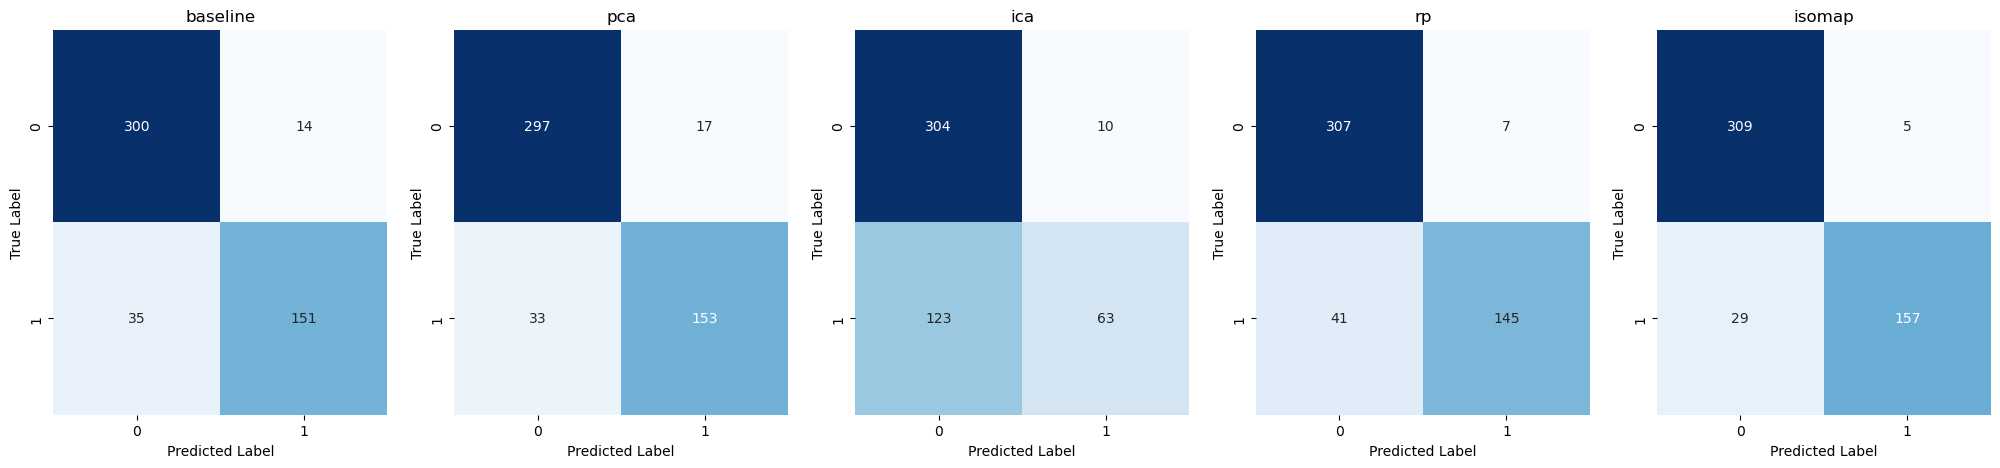

In [202]:
# fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

axes = axes.flatten()

for ax, pred, title in zip(axes, kmeans_preds, titles):
    sns.heatmap(confusion_matrix(y_train, pred), annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'{title}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

In [203]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

kmeans_metrics_results = []

for pred in kmeans_preds:
    accuracy = accuracy_score(y_train, pred)
    try:
        roc_auc = roc_auc_score(y_train, pred)
    except ValueError:
        roc_auc = np.nan
    precision = precision_score(y_train, pred)
    recall = recall_score(y_train, pred)
    f1 = f1_score(y_train, pred)
    
    kmeans_metrics_results.append([accuracy, roc_auc, precision, recall, f1])

kmeans_metrics_df = pd.DataFrame(kmeans_metrics_results, columns=['Accuracy', 'ROC AUC', 'Precision', 'Recall', 'F1'], index=titles)

In [204]:
kmeans_metrics_df.style.highlight_max(axis=0, color='lightgreen').highlight_min(axis=0, color='pink')

,Accuracy,ROC AUC,Precision,Recall,F1
baseline,0.902000,0.883621,0.915152,0.811828,0.860399
pca,0.900000,0.884220,0.900000,0.822581,0.859551
ica,0.734000,0.653431,0.863014,0.338710,0.486486
rp,0.904000,0.878638,0.953947,0.779570,0.857988
isomap,0.932000,0.914081,0.969136,0.844086,0.902299


In [205]:
red_clustering_evals['gmm'] = {}
red_clustering_model_data['gmm'] = {}

In [206]:
red_clustering_evals['gmm']['baseline'] = {}
red_clustering_model_data['gmm']['baseline'] = {}


red_clustering_evals['gmm']['baseline']['Log-Likelihood'] = gmm.score(pd.DataFrame(X_train, columns=data.columns[:-1]))
red_clustering_evals['gmm']['baseline']['AIC'] = gmm.aic(pd.DataFrame(X_train, columns=data.columns[:-1]))
red_clustering_evals['gmm']['baseline']['BIC'] = gmm.bic(pd.DataFrame(X_train, columns=data.columns[:-1]))
red_clustering_evals['gmm']['baseline']['Silhouette Score'] = silhouette_score(X_train, gmm_labels)
red_clustering_evals['gmm']['baseline']['Davies-Bouldin Index'] = davies_bouldin_score(X_train, gmm_labels)
red_clustering_evals['gmm']['baseline']['Dunn Index'] = dunn_index(X_train, gmm_labels)
red_clustering_evals['gmm']['baseline']['ARI'] = adjusted_rand_score(y_train, gmm_labels)
red_clustering_evals['gmm']['baseline']['NMI'] = normalized_mutual_info_score(y_train, gmm_labels)
red_clustering_evals['gmm']['baseline']['FMI'] = fowlkes_mallows_score(y_train, gmm_labels)

red_clustering_model_data['gmm']['baseline'] = {}
red_clustering_model_data['gmm']['baseline']['labels'] = gmm_labels
red_clustering_model_data['gmm']['baseline']['centers'] = gmm.means_
red_clustering_model_data['gmm']['baseline']['n_iters'] = gmm.n_iter_
red_clustering_model_data['gmm']['baseline']['feature_names'] = gmm.feature_names_in_

In [207]:
red_clustering_evals['gmm']['pca'] = {}
red_clustering_model_data['gmm']['pca'] = {}


red_clustering_evals['gmm']['pca']['Log-Likelihood'] = gmm_pca.score(pd.DataFrame(X_train_pca, columns=[f'Component {i}' for i in range(1, X_train_pca.shape[1]+1)]))
red_clustering_evals['gmm']['pca']['AIC'] = gmm_pca.aic(pd.DataFrame(X_train_pca, columns=[f'Component {i}' for i in range(1, X_train_pca.shape[1]+1)]))
red_clustering_evals['gmm']['pca']['BIC'] = gmm_pca.bic(pd.DataFrame(X_train_pca, columns=[f'Component {i}' for i in range(1, X_train_pca.shape[1]+1)]))
red_clustering_evals['gmm']['pca']['Silhouette Score'] = silhouette_score(X_train_pca, gmm_pca_labels)
red_clustering_evals['gmm']['pca']['Davies-Bouldin Index'] = davies_bouldin_score(X_train_pca, gmm_pca_labels)
red_clustering_evals['gmm']['pca']['Dunn Index'] = dunn_index(X_train_pca, gmm_pca_labels)
red_clustering_evals['gmm']['pca']['ARI'] = adjusted_rand_score(y_train, gmm_pca_labels)
red_clustering_evals['gmm']['pca']['NMI'] = normalized_mutual_info_score(y_train, gmm_pca_labels)
red_clustering_evals['gmm']['pca']['FMI'] = fowlkes_mallows_score(y_train, gmm_pca_labels)

red_clustering_model_data['gmm']['pca'] = {}
red_clustering_model_data['gmm']['pca']['labels'] = gmm_pca_labels
red_clustering_model_data['gmm']['pca']['centers'] = gmm_pca.means_
red_clustering_model_data['gmm']['pca']['n_iters'] = gmm_pca.n_iter_
red_clustering_model_data['gmm']['pca']['feature_names'] = gmm_pca.feature_names_in_

In [208]:
red_clustering_evals['gmm']['ica'] = {}
red_clustering_model_data['gmm']['ica'] = {}

red_clustering_evals['gmm']['ica']['Log-Likelihood'] = gmm_ica.score(pd.DataFrame(X_train_ica, columns=[f'Component {i}' for i in range(1, X_train_ica.shape[1]+1)]))
red_clustering_evals['gmm']['ica']['AIC'] = gmm_ica.aic(pd.DataFrame(X_train_ica, columns=[f'Component {i}' for i in range(1, X_train_ica.shape[1]+1)]))
red_clustering_evals['gmm']['ica']['BIC'] = gmm_ica.bic(pd.DataFrame(X_train_ica, columns=[f'Component {i}' for i in range(1, X_train_ica.shape[1]+1)]))
red_clustering_evals['gmm']['ica']['Silhouette Score'] = silhouette_score(X_train_ica, gmm_ica_labels)
red_clustering_evals['gmm']['ica']['Davies-Bouldin Index'] = davies_bouldin_score(X_train_ica, gmm_ica_labels)
red_clustering_evals['gmm']['ica']['Dunn Index'] = dunn_index(X_train_ica, gmm_ica_labels)
red_clustering_evals['gmm']['ica']['ARI'] = adjusted_rand_score(y_train, gmm_ica_labels)
red_clustering_evals['gmm']['ica']['NMI'] = normalized_mutual_info_score(y_train, gmm_ica_labels)
red_clustering_evals['gmm']['ica']['FMI'] = fowlkes_mallows_score(y_train, gmm_ica_labels)

red_clustering_model_data['gmm']['ica'] = {}
red_clustering_model_data['gmm']['ica']['labels'] = gmm_ica_labels
red_clustering_model_data['gmm']['ica']['centers'] = gmm_ica.means_
red_clustering_model_data['gmm']['ica']['n_iters'] = gmm_ica.n_iter_
red_clustering_model_data['gmm']['ica']['feature_names'] = gmm_ica.feature_names_in_

In [209]:
# red_clustering_evals['gmm']['ica_subset'] = {}
# red_clustering_model_data['gmm']['ica_subset'] = {}

# red_clustering_evals['gmm']['ica_subset']['Log-Likelihood'] = gmm_ica_selected.score(X_train_ica_selected)
# red_clustering_evals['gmm']['ica_subset']['AIC'] = gmm_ica_selected.aic(X_train_ica_selected)
# red_clustering_evals['gmm']['ica_subset']['BIC'] = gmm_ica_selected.bic(X_train_ica_selected)
# red_clustering_evals['gmm']['ica_subset']['Silhouette Score'] = silhouette_score(X_train_ica_selected, gmm_ica_selected_labels)
# red_clustering_evals['gmm']['ica_subset']['Davies-Bouldin Index'] = davies_bouldin_score(X_train_ica_selected, gmm_ica_selected_labels)
# red_clustering_evals['gmm']['ica_subset']['Dunn Index'] = dunn_index(X_train_ica_selected, gmm_ica_selected_labels)
# red_clustering_evals['gmm']['ica_subset']['ARI'] = adjusted_rand_score(y_train, gmm_ica_selected_labels)
# red_clustering_evals['gmm']['ica_subset']['NMI'] = normalized_mutual_info_score(y_train, gmm_ica_selected_labels)
# red_clustering_evals['gmm']['ica_subset']['FMI'] = fowlkes_mallows_score(y_train, gmm_ica_selected_labels)

# red_clustering_model_data['gmm']['ica_subset'] = {}
# red_clustering_model_data['gmm']['ica_subset']['labels'] = gmm_ica_selected_labels
# red_clustering_model_data['gmm']['ica_subset']['centers'] = gmm_ica_selected.means_

In [210]:
red_clustering_evals['gmm']['rp'] = {}
red_clustering_model_data['gmm']['rp'] = {}

red_clustering_evals['gmm']['rp']['Log-Likelihood'] = gmm_rp.score(pd.DataFrame(X_train_rp, columns=[f'Component {i}' for i in range(1, X_train_rp.shape[1]+1)]))
red_clustering_evals['gmm']['rp']['AIC'] = gmm_rp.aic(pd.DataFrame(X_train_rp, columns=[f'Component {i}' for i in range(1, X_train_rp.shape[1]+1)]))
red_clustering_evals['gmm']['rp']['BIC'] = gmm_rp.bic(pd.DataFrame(X_train_rp, columns=[f'Component {i}' for i in range(1, X_train_rp.shape[1]+1)]))
red_clustering_evals['gmm']['rp']['Silhouette Score'] = silhouette_score(X_train_rp, gmm_rp_labels)
red_clustering_evals['gmm']['rp']['Davies-Bouldin Index'] = davies_bouldin_score(X_train_rp, gmm_rp_labels)
red_clustering_evals['gmm']['rp']['Dunn Index'] = dunn_index(X_train_rp, gmm_rp_labels)
red_clustering_evals['gmm']['rp']['ARI'] = adjusted_rand_score(y_train, gmm_rp_labels)
red_clustering_evals['gmm']['rp']['NMI'] = normalized_mutual_info_score(y_train, gmm_rp_labels)
red_clustering_evals['gmm']['rp']['FMI'] = fowlkes_mallows_score(y_train, gmm_rp_labels)

red_clustering_model_data['gmm']['rp'] = {}
red_clustering_model_data['gmm']['rp']['labels'] = gmm_rp_labels
red_clustering_model_data['gmm']['rp']['centers'] = gmm_rp.means_
red_clustering_model_data['gmm']['rp']['n_iters'] = gmm_rp.n_iter_
red_clustering_model_data['gmm']['rp']['feature_names'] = gmm_rp.feature_names_in_

In [211]:
red_clustering_evals['gmm']['isomap'] = {}
red_clustering_model_data['gmm']['isomap'] = {}

red_clustering_evals['gmm']['isomap']['Log-Likelihood'] = gmm_isomap.score(pd.DataFrame(X_train_isomap, columns=[f'Component {i}' for i in range(1, X_train_isomap.shape[1]+1)]))
red_clustering_evals['gmm']['isomap']['AIC'] = gmm_isomap.aic(pd.DataFrame(X_train_isomap, columns=[f'Component {i}' for i in range(1, X_train_isomap.shape[1]+1)]))
red_clustering_evals['gmm']['isomap']['BIC'] = gmm_isomap.bic(pd.DataFrame(X_train_isomap, columns=[f'Component {i}' for i in range(1, X_train_isomap.shape[1]+1)]))
red_clustering_evals['gmm']['isomap']['Silhouette Score'] = silhouette_score(X_train_isomap, gmm_isomap_labels)
red_clustering_evals['gmm']['isomap']['Davies-Bouldin Index'] = davies_bouldin_score(X_train_isomap, gmm_isomap_labels)
red_clustering_evals['gmm']['isomap']['Dunn Index'] = dunn_index(X_train_isomap, gmm_isomap_labels)
red_clustering_evals['gmm']['isomap']['ARI'] = adjusted_rand_score(y_train, gmm_isomap_labels)
red_clustering_evals['gmm']['isomap']['NMI'] = normalized_mutual_info_score(y_train, gmm_isomap_labels)
red_clustering_evals['gmm']['isomap']['FMI'] = fowlkes_mallows_score(y_train, gmm_isomap_labels)

red_clustering_model_data['gmm']['isomap'] = {}
red_clustering_model_data['gmm']['isomap']['labels'] = gmm_isomap_labels
red_clustering_model_data['gmm']['isomap']['centers'] = gmm_isomap.means_
red_clustering_model_data['gmm']['isomap']['n_iters'] = gmm_isomap.n_iter_
red_clustering_model_data['gmm']['isomap']['feature_names'] = gmm_isomap.feature_names_in_

In [212]:
red_clustering_gmm_evals_df = pd.DataFrame(red_clustering_evals['gmm']).T

red_clustering_gmm_evals_df.style.highlight_max(axis=0, props='background-color:lightgreen;', subset=['Log-Likelihood', 'Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI']) \
    .highlight_min(axis=0, props='background-color:lightgreen;', subset=['AIC', 'BIC', 'Davies-Bouldin Index']) \
    .highlight_max(axis=0, props='background-color:pink;', subset=['AIC', 'BIC', 'Davies-Bouldin Index']) \
    .highlight_min(axis=0, props='background-color:pink;', subset=['Log-Likelihood', 'Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI'])

,Log-Likelihood,AIC,BIC,Silhouette Score,Davies-Bouldin Index,Dunn Index,ARI,NMI,FMI
baseline,0.374964,1607.036033,5783.712658,0.314282,1.381813,0.184723,0.759049,0.644745,0.886720
pca,-12.113179,12255.179105,12554.416280,0.290325,1.465821,0.124562,0.423036,0.324673,0.724320
ica,-21.790723,22548.723163,24146.059632,0.187814,4.878404,0.278941,0.224422,0.144621,0.656917
rp,-4.963680,5973.679761,8102.056851,0.364766,1.258752,0.193172,0.537178,0.418421,0.790190
isomap,-14.373050,14483.050010,14714.853456,0.243902,1.506813,0.160070,0.363515,0.348748,0.692016


In [222]:
red_clustering_gmm_evals_df[['Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].rename(columns={'Silhouette Score':'Silhouette', 'Davies-Bouldin Index':'Davies-Bouldin', 'Dunn Index':'Dunn'})\
    .style.highlight_max(axis=0, props='background-color:lightgreen;', subset=['Silhouette', 'Dunn', ]) \
    .highlight_min(axis=0, props='background-color:lightgreen;', subset=['Davies-Bouldin']) \
    .highlight_max(axis=0, props='background-color:pink;', subset=['Davies-Bouldin']) \
    .highlight_min(axis=0, props='background-color:pink;', subset=['Silhouette', 'Dunn', ])

,Silhouette,Davies-Bouldin,Dunn
baseline,0.314282,1.381813,0.184723
pca,0.290325,1.465821,0.124562
ica,0.187814,4.878404,0.278941
rp,0.364766,1.258752,0.193172
isomap,0.243902,1.506813,0.160070


In [264]:
red_clustering_gmm_evals_df[['Silhouette Score', 'Davies-Bouldin Index', 'ARI']].rename(columns={'Silhouette Score':'Silhouette', 'Davies-Bouldin Index':'Davies-Bouldin'})\
    .style.highlight_max(axis=0, props='background-color:lightgreen;', subset=['Silhouette', 'ARI', ]) \
    .highlight_min(axis=0, props='background-color:lightgreen;', subset=['Davies-Bouldin']) \
    .highlight_max(axis=0, props='background-color:pink;', subset=['Davies-Bouldin']) \
    .highlight_min(axis=0, props='background-color:pink;', subset=['Silhouette', 'ARI', ])

,Silhouette,Davies-Bouldin,ARI
baseline,0.314282,1.381813,0.759049
pca,0.290325,1.465821,0.423036
ica,0.187814,4.878404,0.224422
rp,0.364766,1.258752,0.537178
isomap,0.243902,1.506813,0.363515


In [213]:
gmm_preds = [gmm_labels, gmm_pca_labels, gmm_ica_labels, gmm_rp_labels, gmm_isomap_labels]

In [214]:
gmm_invert = []

for i in range(len(gmm_preds)):
    if np.sum(gmm_preds[i] == y_train) < np.sum(np.logical_not(gmm_preds[i]).astype(int) == y_train):
        gmm_invert.append(True)
        gmm_preds[i] = np.logical_not(gmm_preds[i]).astype(int)
    else:
        gmm_invert.append(False)

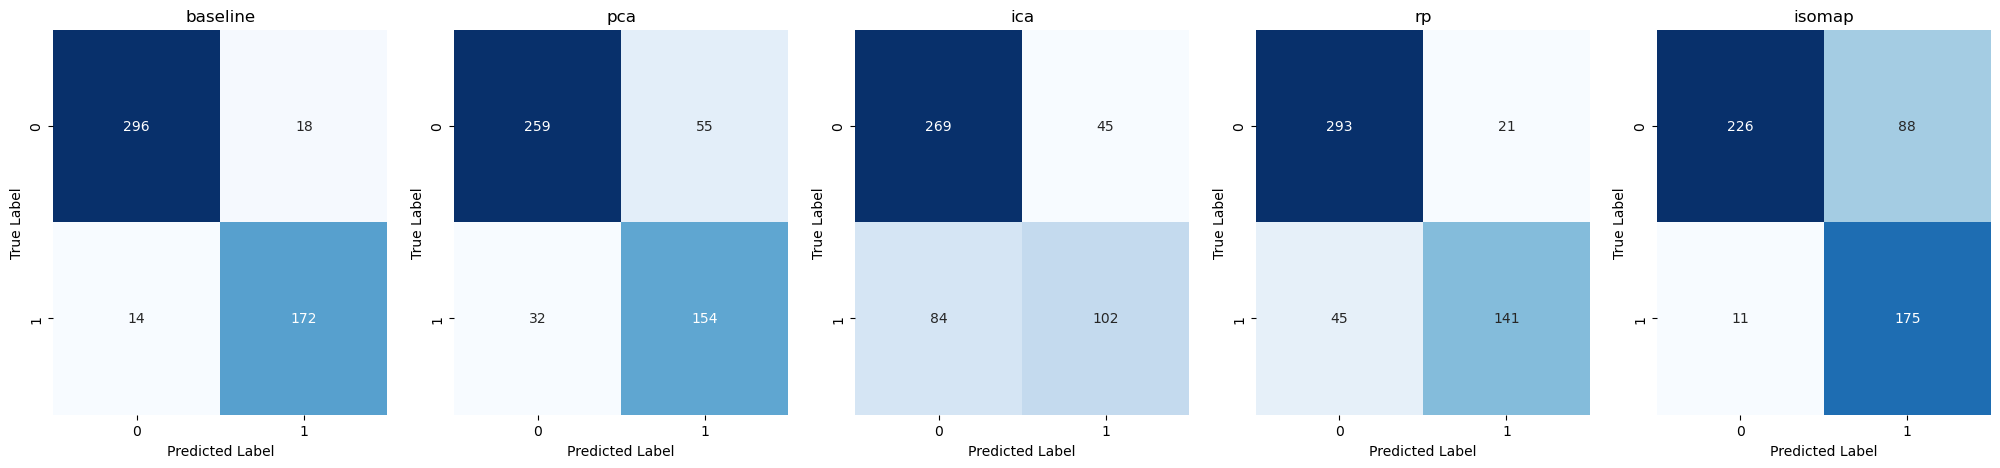

In [216]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

axes = axes.flatten()

for ax, pred, title in zip(axes, gmm_preds, titles):
    sns.heatmap(confusion_matrix(y_train, pred), annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'{title}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

In [220]:
gmm_metrics_results = []

for pred in gmm_preds:
    accuracy = accuracy_score(y_train, pred)
    try:
        roc_auc = roc_auc_score(y_train, pred)
    except ValueError:
        roc_auc = np.nan
    precision = precision_score(y_train, pred)
    recall = recall_score(y_train, pred)
    f1 = f1_score(y_train, pred)
    
    gmm_metrics_results.append([accuracy, roc_auc, precision, recall, f1])

gmm_metrics_df = pd.DataFrame(gmm_metrics_results, columns=['Accuracy', 'ROC AUC', 'Precision', 'Recall', 'F1'], index=titles)

In [221]:
gmm_metrics_df.style.highlight_max(axis=0, color='lightgreen').highlight_min(axis=0, color='pink')

,Accuracy,ROC AUC,Precision,Recall,F1
baseline,0.936000,0.933703,0.905263,0.924731,0.914894
pca,0.826000,0.826399,0.736842,0.827957,0.779747
ica,0.742000,0.702537,0.693878,0.548387,0.612613
rp,0.868000,0.845593,0.870370,0.758065,0.810345
isomap,0.802000,0.830303,0.665399,0.940860,0.779510


In [106]:
# all_datasets = {
#     'baseline': {'train': X_train},
#     'pca': {'train': X_train_pca},
#     'ica': {'train': X_train_ica},
#     'ica_subset': {'train': X_train_ica_selected},
#     'rp': {'train': X_train_rp},
#     'isomap': {'train': X_train_isomap},
#     # 'mds': {'train': X_train_mds},
# }

In [107]:
# all_models_data = {}

# all_models_data['kmeans'] = {}

# all_models_data['kmeans']['baseline'] = {}
# all_models_data['kmeans']['pca'] = {}
# all_models_data['kmeans']['ica'] = {}
# all_models_data['kmeans']['ica_subset'] = {}
# all_models_data['kmeans']['rp'] = {}
# all_models_data['kmeans']['isomap'] = {}
# # all_models_data['kmeans']['mds'] = {}

# all_models_data['kmeans']['baseline']['labels'] = kmeans_labels
# all_models_data['kmeans']['baseline']['centers'] = kmeans.cluster_centers_

# all_models_data['kmeans']['pca']['labels'] = kmeans_pca_labels
# all_models_data['kmeans']['pca']['centers'] = kmeans_pca.cluster_centers_

# all_models_data['kmeans']['ica']['labels'] = kmeans_ica_labels
# all_models_data['kmeans']['ica']['centers'] = kmeans_ica.cluster_centers_

# all_models_data['kmeans']['ica_subset']['labels'] = kmeans_ica_selected_labels
# all_models_data['kmeans']['ica_subset']['centers'] = kmeans_ica_selected.cluster_centers_

# all_models_data['kmeans']['rp']['labels'] = kmeans_rp_labels
# all_models_data['kmeans']['rp']['centers'] = kmeans_rp.cluster_centers_

# all_models_data['kmeans']['isomap']['labels'] = kmeans_isomap_labels
# all_models_data['kmeans']['isomap']['centers'] = kmeans_isomap.cluster_centers_

# # all_models_data['kmeans']['mds']['labels'] = kmeans_mds_labels
# # all_models_data['kmeans']['mds']['centers'] = kmeans_mds.cluster_centers_


# all_models_data['gmm'] = {}

# all_models_data['gmm']['baseline'] = {}
# all_models_data['gmm']['pca'] = {}
# all_models_data['gmm']['ica'] = {}
# all_models_data['gmm']['ica_subset'] = {}
# all_models_data['gmm']['rp'] = {}
# all_models_data['gmm']['isomap'] = {}
# # all_models_data['gmm']['mds'] = {}

# all_models_data['gmm']['baseline']['labels'] = gmm_labels
# all_models_data['gmm']['baseline']['centers'] = gmm.means_

# all_models_data['gmm']['pca']['labels'] = gmm_pca_labels
# all_models_data['gmm']['pca']['centers'] = gmm_pca.means_

# all_models_data['gmm']['ica']['labels'] = gmm_ica_labels
# all_models_data['gmm']['ica']['centers'] = gmm_ica.means_

# all_models_data['gmm']['ica_subset']['labels'] = gmm_ica_selected_labels
# all_models_data['gmm']['ica_subset']['centers'] = gmm_ica_selected.means_

# all_models_data['gmm']['rp']['labels'] = gmm_rp_labels
# all_models_data['gmm']['rp']['centers'] = gmm_rp.means_

# all_models_data['gmm']['isomap']['labels'] = gmm_isomap_labels
# all_models_data['gmm']['isomap']['centers'] = gmm_isomap.means_

# # all_models_data['gmm']['mds']['labels'] = gmm_mds_labels
# # all_models_data['gmm']['mds']['centers'] = gmm_mds.means_

In [232]:
pd.DataFrame(cluster_times['kmeans'], index=[0])

,baseline,pca,ica,rp,isomap
0,0.00299,0.001956,0.00299,0.001992,0.000997


In [233]:
pd.DataFrame(dim_red_times, index=[0])

,pca,ica,rp,isomap
0,0.001993,0.008969,0.000997,0.07774


In [223]:
X_test_pca = pca.transform(X_test)
X_test_ica = ica.transform(X_test)
# X_test_ica_selected = X_test_ica[:, list(reversed(top_ica_components.tolist()))]
X_test_rp = rp.transform(X_test)
X_test_isomap = isomap.transform(X_test)
# X_test_mds = project_mds(X_train, X_train_mds, X_test)

In [225]:
test_kmeans_preds = [
    kmeans.predict(pd.DataFrame(X_test, columns=data.columns[:-1])),
    kmeans_pca.predict(pd.DataFrame(X_test_pca, columns=[f'Component {i}' for i in range(1, X_test_pca.shape[1]+1)])),
    kmeans_ica.predict(pd.DataFrame(X_test_ica, columns=[f'Component {i}' for i in range(1, X_test_ica.shape[1]+1)])),
    # kmeans_ica_selected.predict(X_test_ica_selected),
    kmeans_rp.predict(pd.DataFrame(X_test_rp, columns=[f'Component {i}' for i in range(1, X_test_rp.shape[1]+1)])),
    kmeans_isomap.predict(pd.DataFrame(X_test_isomap, columns=[f'Component {i}' for i in range(1, X_test_isomap.shape[1]+1)])),
    # kmeans_mds.predict(X_test_mds),
]

test_gmm_preds = [
    gmm.predict(pd.DataFrame(X_test, columns=data.columns[:-1])),
    gmm_pca.predict(pd.DataFrame(X_test_pca, columns=[f'Component {i}' for i in range(1, X_test_pca.shape[1]+1)])),
    gmm_ica.predict(pd.DataFrame(X_test_ica, columns=[f'Component {i}' for i in range(1, X_test_ica.shape[1]+1)])),
    # gmm_ica_selected.predict(X_test_ica_selected),
    gmm_rp.predict(pd.DataFrame(X_test_rp, columns=[f'Component {i}' for i in range(1, X_test_rp.shape[1]+1)])),
    gmm_isomap.predict(pd.DataFrame(X_test_isomap, columns=[f'Component {i}' for i in range(1, X_test_isomap.shape[1]+1)])),
    # gmm_mds.predict(X_test_mds),
]

In [226]:
for i in range(len(test_kmeans_preds)):
    if kmeans_invert[i]:
        test_kmeans_preds[i] = np.logical_not(test_kmeans_preds[i]).astype(int)

for i in range(len(test_gmm_preds)):
    if gmm_invert[i]:
        test_gmm_preds[i] = np.logical_not(test_gmm_preds[i]).astype(int)

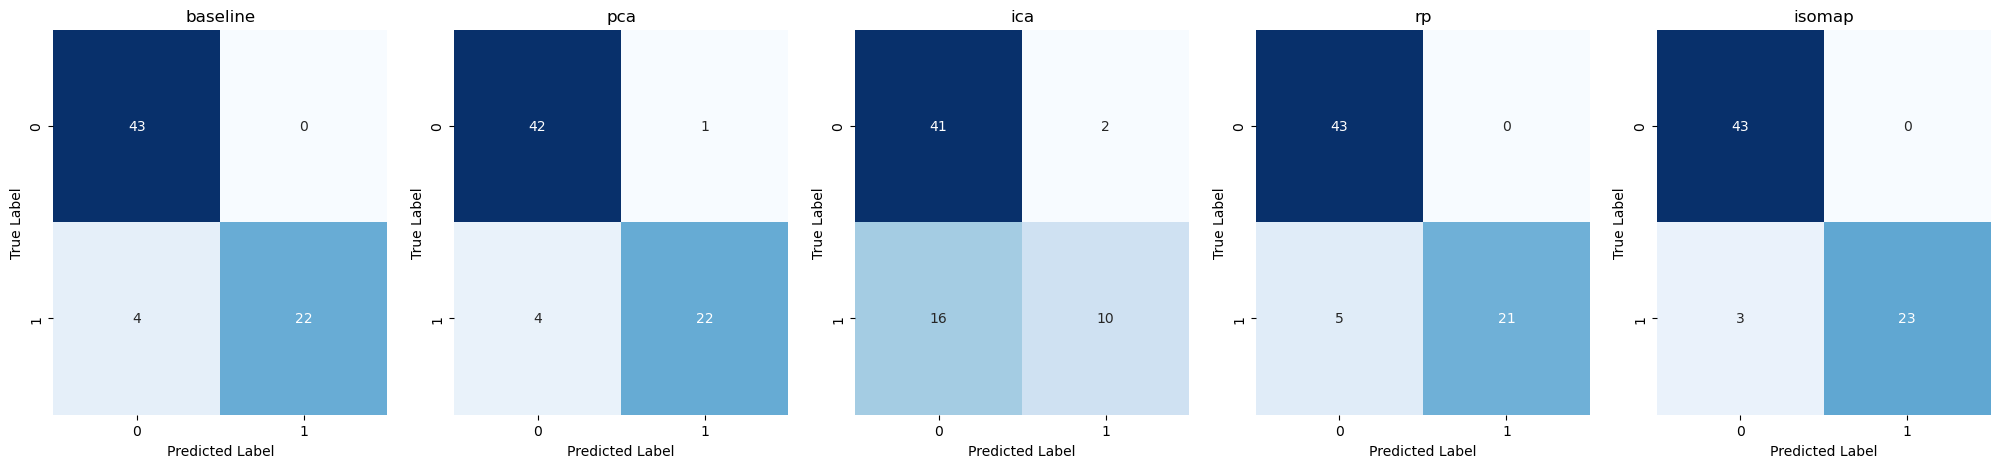

In [229]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

axes = axes.flatten()

for ax, pred, title in zip(axes, test_kmeans_preds, titles):
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'{title}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

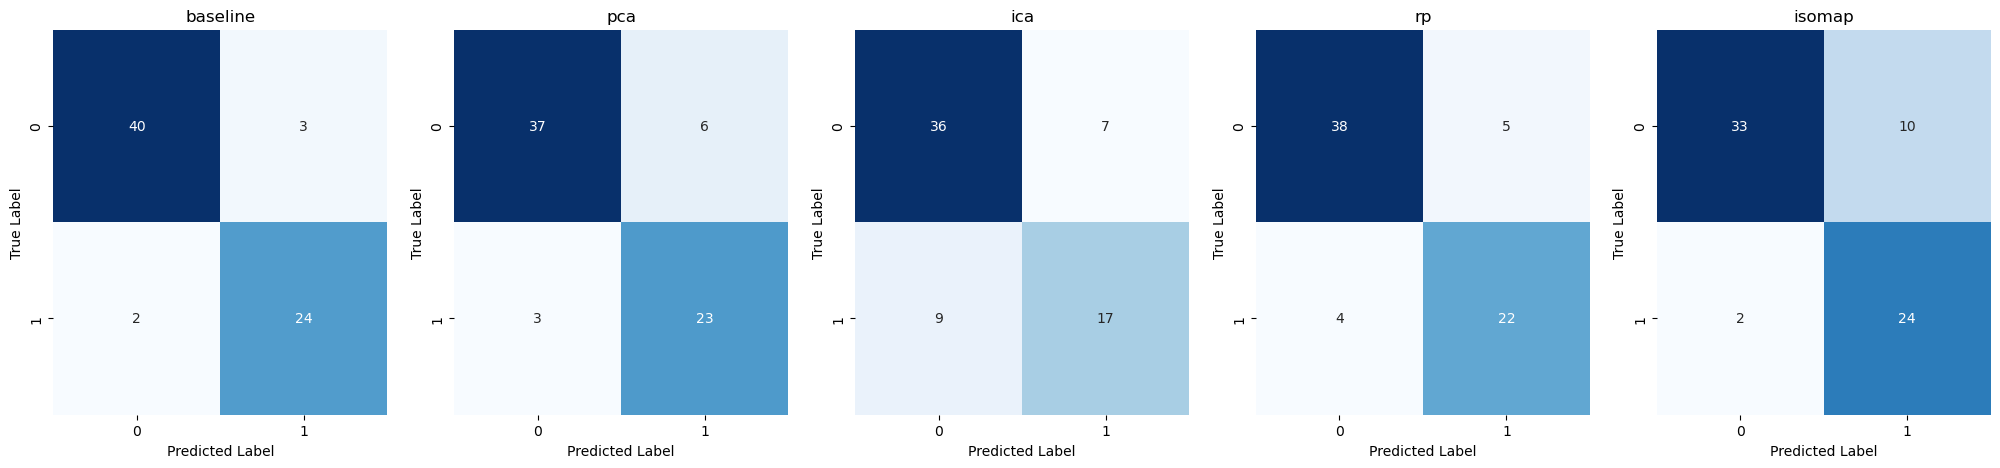

In [231]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

axes = axes.flatten()

for ax, pred, title in zip(axes, test_gmm_preds, titles):
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'{title}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

In [269]:
kmeans_test_metrics_results = []

for pred in test_kmeans_preds:
    accuracy = accuracy_score(y_test, pred)
    try:
        roc_auc = roc_auc_score(y_test, pred)
    except ValueError:
        roc_auc = np.nan
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    kmeans_test_metrics_results.append([accuracy, roc_auc, precision, recall, f1])

kmeans_test_metrics_df = pd.DataFrame(kmeans_test_metrics_results, columns=['Accuracy', 'ROC AUC', 'Precision', 'Recall', 'F1'], index=titles)

In [271]:
kmeans_test_metrics_df.style.highlight_max(axis=0, color='lightgreen').highlight_min(axis=0, color='pink')

,Accuracy,ROC AUC,Precision,Recall,F1
baseline,0.942029,0.923077,1.000000,0.846154,0.916667
pca,0.927536,0.911449,0.956522,0.846154,0.897959
ica,0.739130,0.669052,0.833333,0.384615,0.526316
rp,0.927536,0.903846,1.000000,0.807692,0.893617
isomap,0.956522,0.942308,1.000000,0.884615,0.938776


In [273]:
gmm_test_metrics_results = []

for pred in test_gmm_preds:
    accuracy = accuracy_score(y_test, pred)
    try:
        roc_auc = roc_auc_score(y_test, pred)
    except ValueError:
        roc_auc = np.nan
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    gmm_test_metrics_results.append([accuracy, roc_auc, precision, recall, f1])

gmm_test_metrics_df = pd.DataFrame(gmm_test_metrics_results, columns=['Accuracy', 'ROC AUC', 'Precision', 'Recall', 'F1'], index=titles)

In [274]:
gmm_test_metrics_df.style.highlight_max(axis=0, color='lightgreen').highlight_min(axis=0, color='pink')

,Accuracy,ROC AUC,Precision,Recall,F1
baseline,0.927536,0.926655,0.888889,0.923077,0.905660
pca,0.869565,0.872540,0.793103,0.884615,0.836364
ica,0.768116,0.745528,0.708333,0.653846,0.680000
rp,0.869565,0.864937,0.814815,0.846154,0.830189
isomap,0.826087,0.845259,0.705882,0.923077,0.800000


In [131]:
# all_datasets['baseline']['test'] = X_test
# all_datasets['pca']['test'] = X_test_pca
# all_datasets['ica']['test'] = X_test_ica
# all_datasets['ica_subset']['test'] = X_test_ica_selected
# all_datasets['rp']['test'] = X_test_rp
# all_datasets['isomap']['test'] = X_test_isomap

In [132]:
# all_models_data['kmeans']['baseline']['test_labels'] = test_kmeans_preds[0]
# all_models_data['kmeans']['pca']['test_labels'] = test_kmeans_preds[1]
# all_models_data['kmeans']['ica']['test_labels'] = test_kmeans_preds[2]
# all_models_data['kmeans']['ica_subset']['test_labels'] = test_kmeans_preds[3]
# all_models_data['kmeans']['rp']['test_labels'] = test_kmeans_preds[4]
# all_models_data['kmeans']['isomap']['test_labels'] = test_kmeans_preds[5]


# all_models_data['gmm']['baseline']['test_labels'] = test_gmm_preds[0]
# all_models_data['gmm']['pca']['test_labels'] = test_gmm_preds[1]
# all_models_data['gmm']['ica']['test_labels'] = test_gmm_preds[2]
# all_models_data['gmm']['ica_subset']['test_labels'] = test_gmm_preds[3]
# all_models_data['gmm']['rp']['test_labels'] = test_gmm_preds[4]
# all_models_data['gmm']['isomap']['test_labels'] = test_gmm_preds[5]

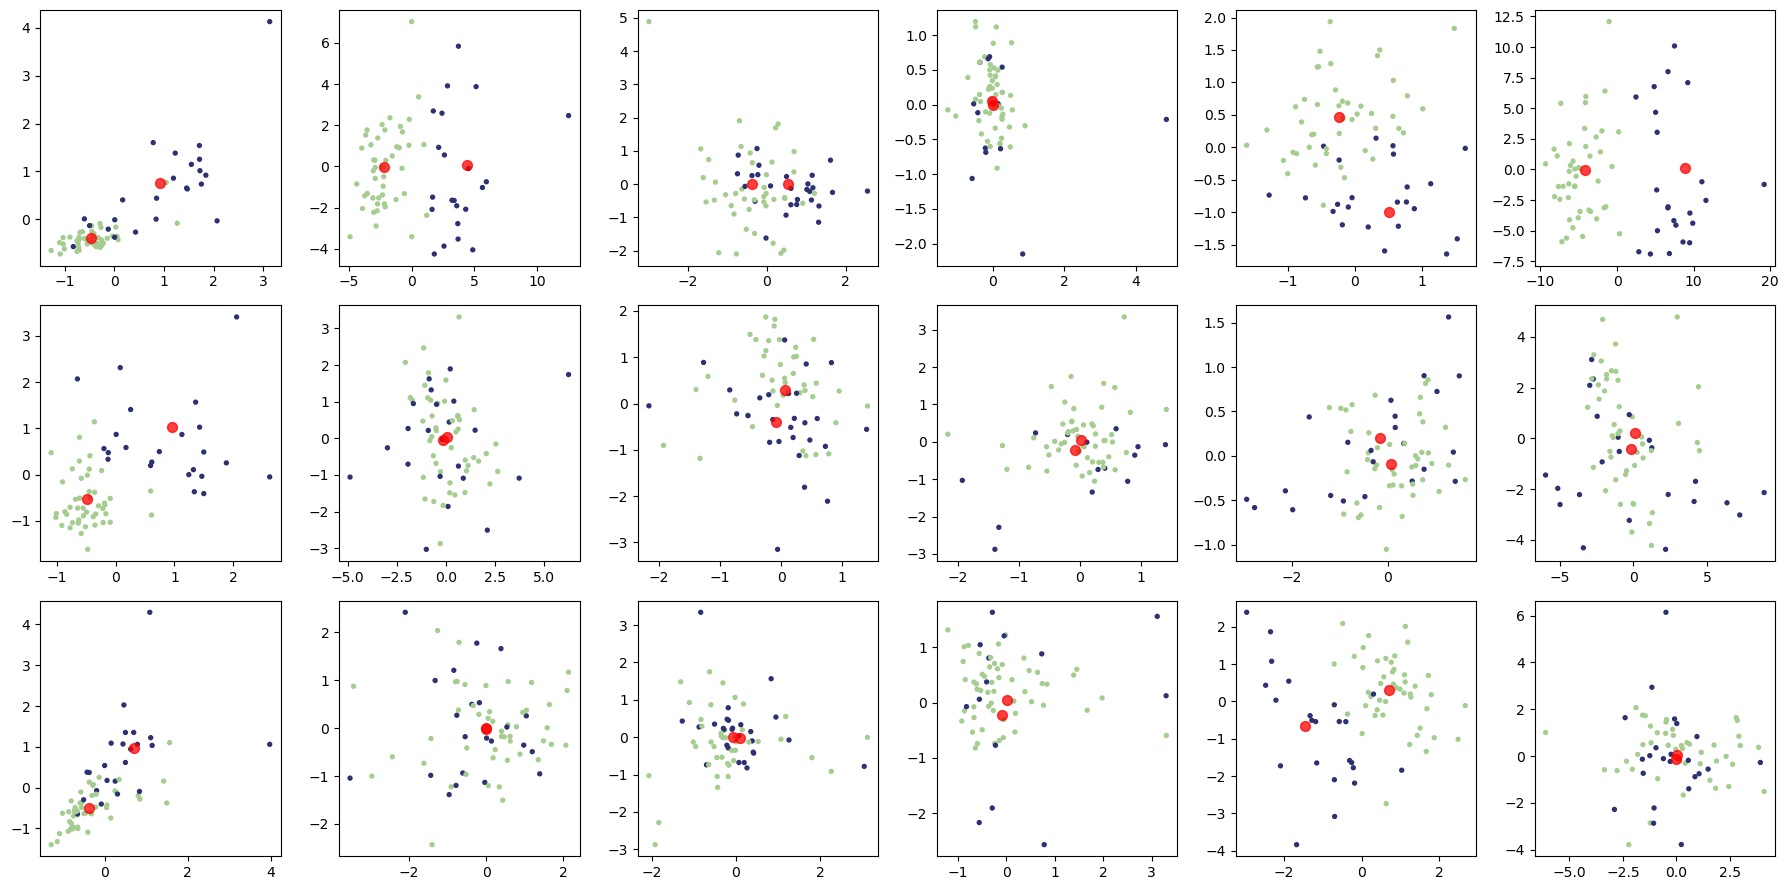

In [133]:
# fig, axes = plt.subplots(
#                 nrows=3, 
#                 ncols=6, 
#                 figsize=(18, 9)
#             )

# axes = axes.flatten()

# for col, model, ax in zip(sorted(np.linspace(0, 4, 3).astype('int').tolist() * 6), ['baseline', 'pca', 'ica', 'ica_subset', 'rp', 'isomap'] * 3, axes):
#     ax.scatter(all_datasets[model]['test'][:, col], all_datasets[model]['test'][:, col+1], c=all_models_data['kmeans'][model]['test_labels'], s=8, cmap='crest')
#     ax.scatter(all_models_data['kmeans'][model]['centers'][:, col], all_models_data['kmeans'][model]['centers'][:, col+1], c='red', s=50, alpha=0.75)

# plt.tight_layout()
# plt.show()

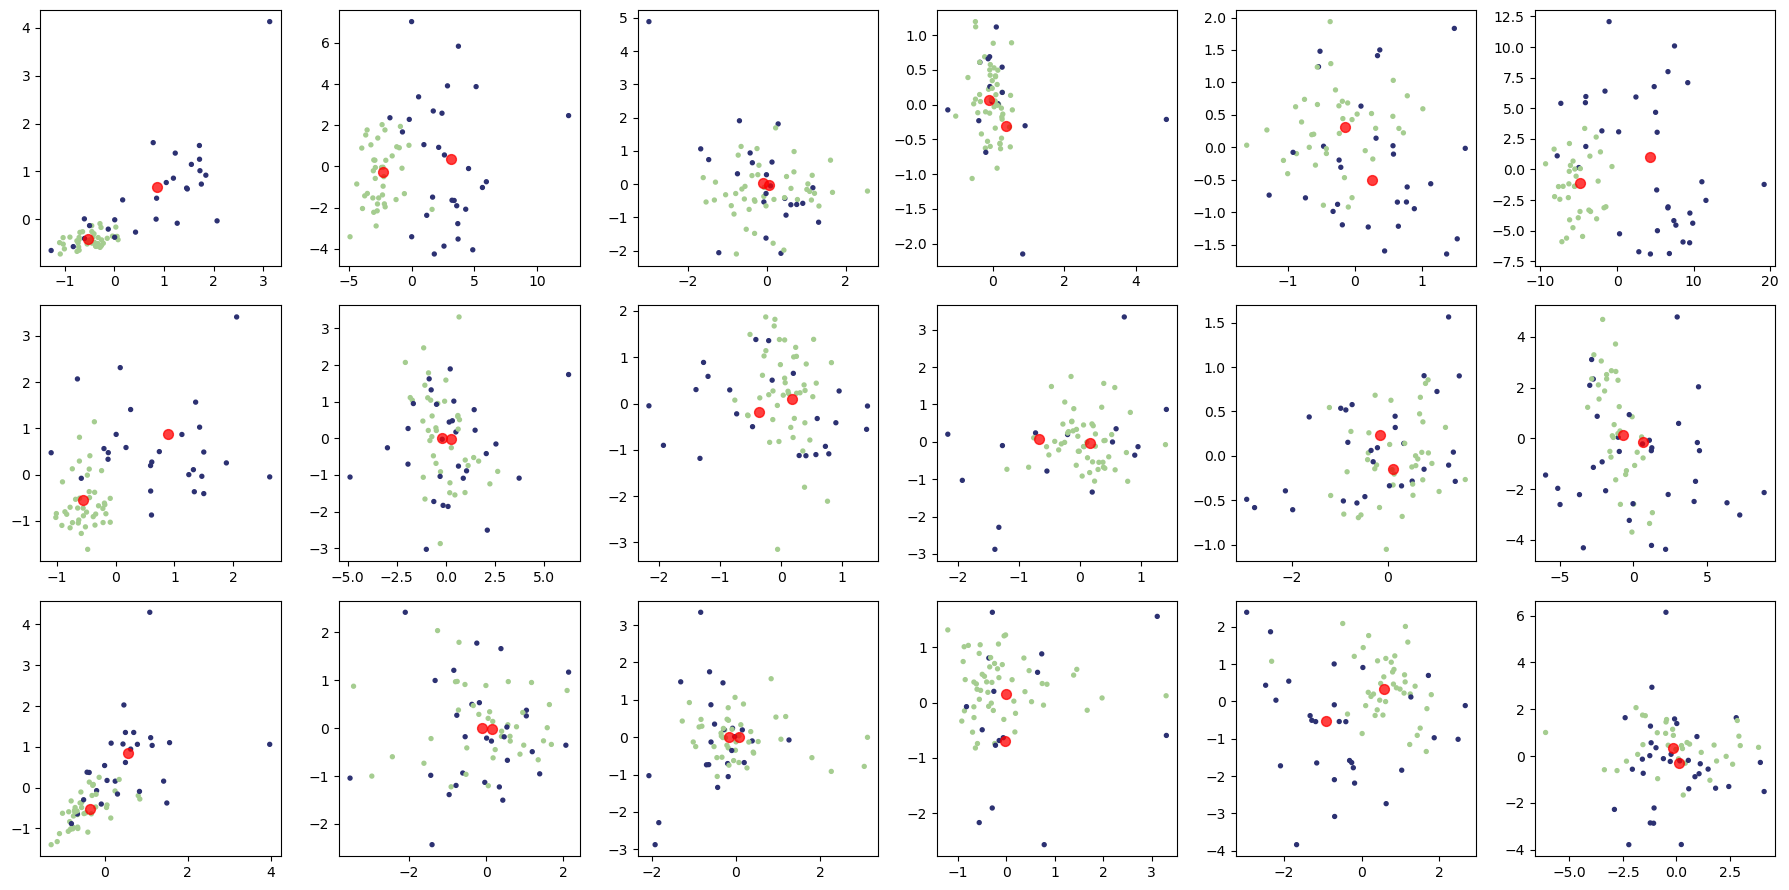

In [134]:
# fig, axes = plt.subplots(
#                 nrows=3, 
#                 ncols=6, 
#                 figsize=(18, 9)
#             )

# axes = axes.flatten()

# for col, model, ax in zip(sorted(np.linspace(0, 4, 3).astype('int').tolist() * 6), ['baseline', 'pca', 'ica', 'ica_subset', 'rp', 'isomap'] * 3, axes):
#     ax.scatter(all_datasets[model]['test'][:, col], all_datasets[model]['test'][:, col+1], c=all_models_data['gmm'][model]['test_labels'], s=8, cmap='crest')
#     ax.scatter(all_models_data['gmm'][model]['centers'][:, col], all_models_data['gmm'][model]['centers'][:, col+1], c='red', s=50, alpha=0.75)

# plt.tight_layout()
# plt.show()

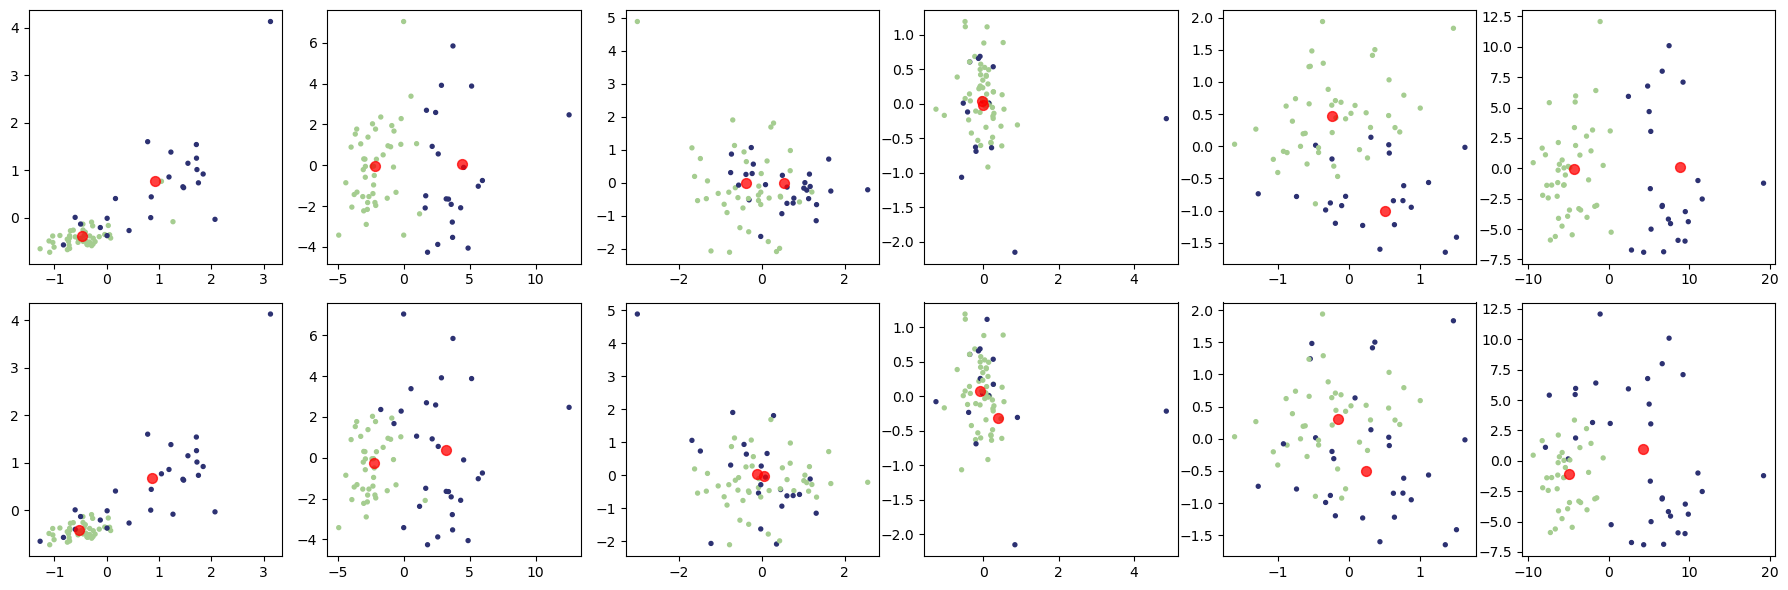

In [135]:
# fig, axes = plt.subplots(
#                 nrows=2, 
#                 ncols=6, 
#                 figsize=(18, 6)
#             )

# axes = axes.flatten()

# for clustering, model, ax in zip(sorted(['kmeans', 'gmm'] * 6, reverse=True), ['baseline', 'pca', 'ica', 'ica_subset', 'rp', 'isomap'] * 2, axes):
#     ax.scatter(all_datasets[model]['test'][:, 0], all_datasets[model]['test'][:, 1], c=all_models_data[clustering][model]['test_labels'], s=8, cmap='crest')
#     ax.scatter(all_models_data[clustering][model]['centers'][:, 0], all_models_data[clustering][model]['centers'][:, 1], c='red', s=50, alpha=0.75)

# plt.tight_layout()
# plt.show()

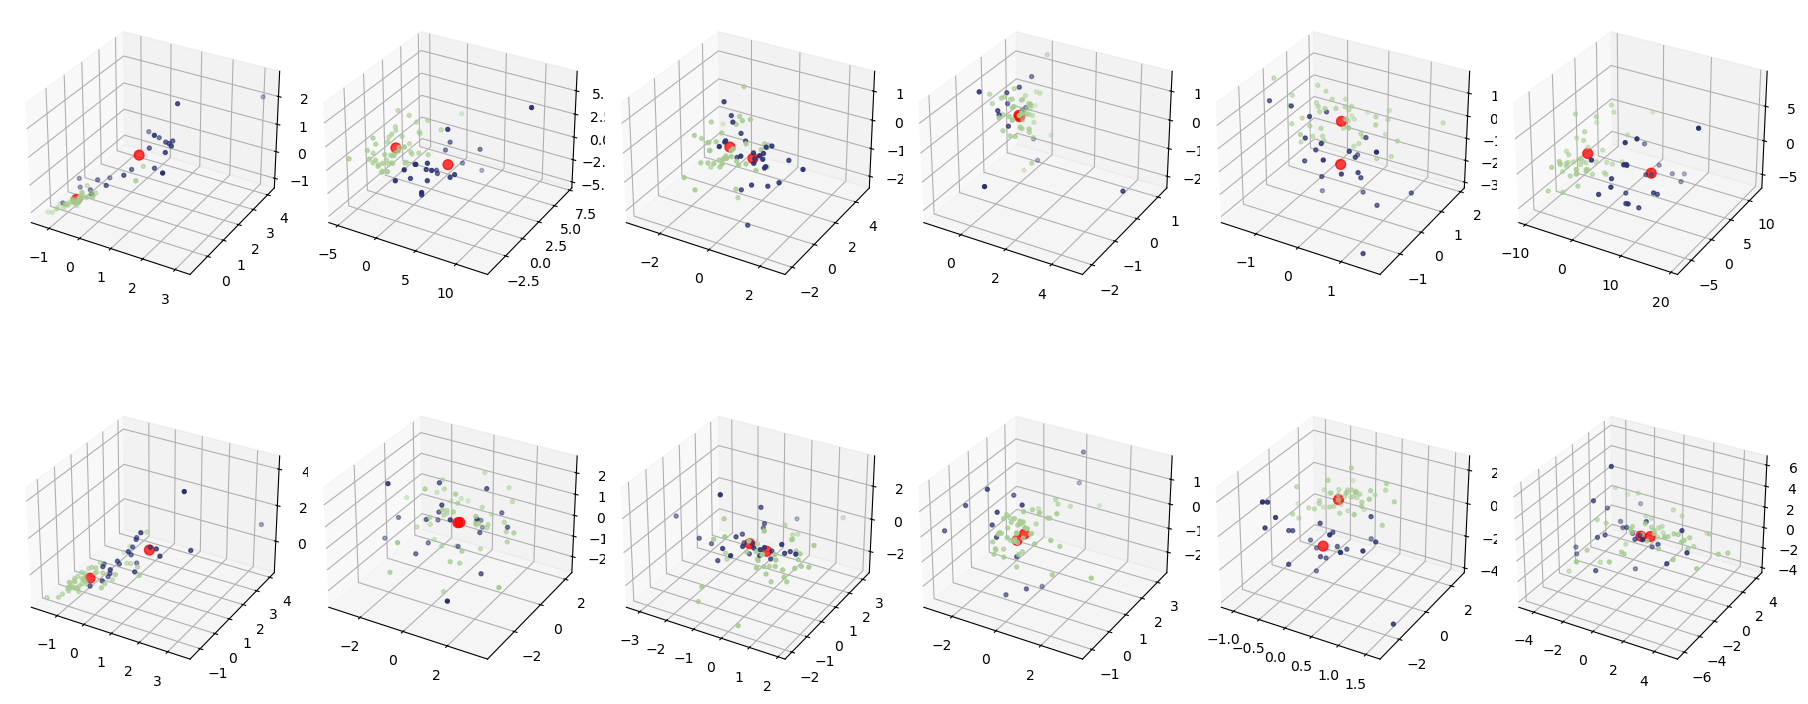

In [136]:
# fig, axes = plt.subplots(
#                 nrows=2, 
#                 ncols=6, 
#                 figsize=(18, 9)
#             )

# axes = axes.flatten()

# for i, col, model, ax in zip(range(2*6), sorted(np.linspace(0, 3, 2).astype('int').tolist() * 6), ['baseline', 'pca', 'ica', 'ica_subset', 'rp', 'isomap'] * 3, axes):
#     ax.remove()  # Remove the current 2D subplot
#     ax = fig.add_subplot(2, 6, i+1, projection='3d')
    
#     ax.scatter(all_datasets[model]['test'][:, col], all_datasets[model]['test'][:, col+1], all_datasets[model]['test'][:, col+2], c=all_models_data['kmeans'][model]['test_labels'], s=8, cmap='crest')
#     ax.scatter(all_models_data['kmeans'][model]['centers'][:, col], all_models_data['kmeans'][model]['centers'][:, col+1], all_models_data['kmeans'][model]['centers'][:, col+2], c='red', s=50, alpha=0.75)

# plt.tight_layout()
# plt.show()

In [139]:
feature_names = data.columns[:-1].to_list()

In [141]:
pd.DataFrame(pca.explained_variance_ratio_, index=[f'PC {i+1}' for i in range(len(pca.explained_variance_ratio_))], columns=['Explained Variance'])

,Explained Variance
PC 1,0.442263
PC 2,0.188453
PC 3,0.093915
PC 4,0.066080
PC 5,0.054938
PC 6,0.041831
PC 7,0.022269


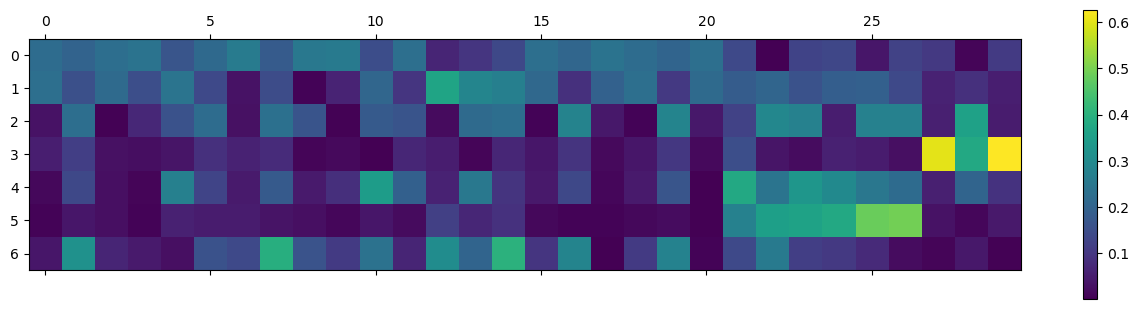

In [151]:
# pd.DataFrame(pca.components_, columns=feature_names)
plt.matshow(pd.DataFrame(np.abs(pca.components_), columns=feature_names))
plt.colorbar()
plt.show()

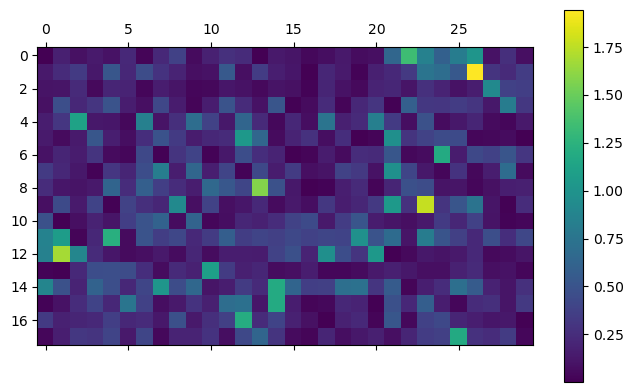

In [145]:
# pd.DataFrame(pca.components_, columns=feature_names)
plt.matshow(pd.DataFrame(np.abs(ica.components_), columns=feature_names))
plt.colorbar()
plt.show()

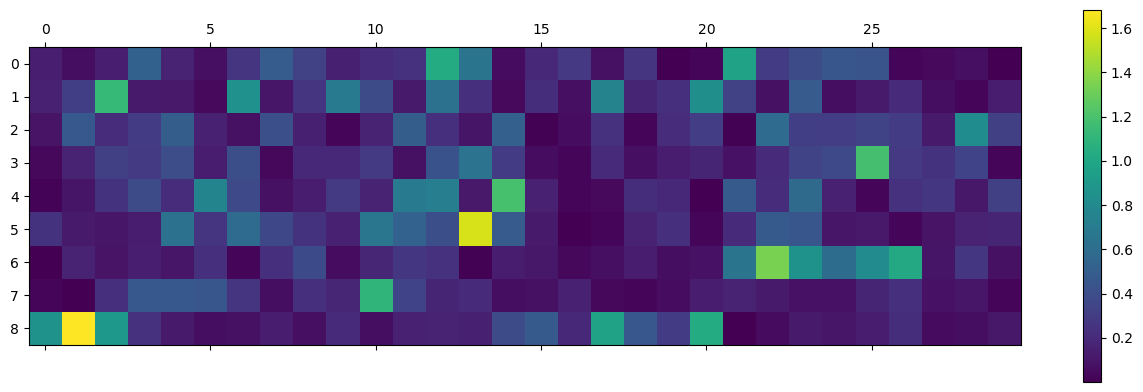

In [158]:
plt.matshow(pd.DataFrame(np.abs(ica.components_[top_ica_components,:])))
plt.colorbar()
plt.show()

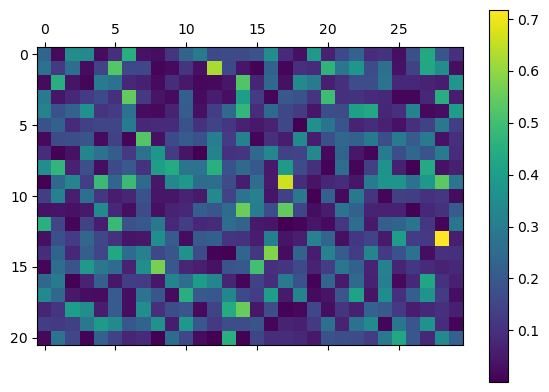

In [159]:
plt.matshow(pd.DataFrame(np.abs(rp.components_.T), index=data.columns[:-1]).T)
plt.colorbar()
plt.show()